# Initializations etc.

## Imports

In [1]:
import math
import os

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats

from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img, array_to_img
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Dropout, GlobalAveragePooling2D, Dense, Softmax, Activation, MaxPooling2D, Flatten, AveragePooling2D
from tensorflow.keras import Model, Sequential
from zipfile import ZipFile

!pip install -U tensorflow-addons
import tensorflow_addons as tfa

!pip install tqdm
from tqdm import tqdm_notebook as tqdm

Requirement already up-to-date: tensorflow-addons in /home/erikb/.pyenv/versions/3.8.2/envs/sci/lib/python3.8/site-packages (0.11.2)


## Globals

In [2]:
AUTO = tf.data.experimental.AUTOTUNE
IMG_WIDTH = 32
IMG_HEIGHT = 32
CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)
CLASSES = 10
TOTAL_NUM_TRAIN_SAMPLES = 50000
matplotlib.rcParams['figure.dpi']= 300

# Datasets & Augmentations

In [4]:
######################################################################################
# ALL TF IMPLEMENTATIONS OF PIL ARE FROM https://github.com/google-research/fixmatch #
######################################################################################

##########
# Cutout #
##########
def cutout(image):
    size = tf.cast(
        tf.random.uniform([], minval=0, maxval=0.5) * IMG_WIDTH, tf.int32)
    if size <= 0:
        return image

    height_loc = tf.random.uniform([],
                                   minval=0,
                                   maxval=IMG_WIDTH,
                                   dtype=tf.int32)
    width_loc = tf.random.uniform([],
                                  minval=0,
                                  maxval=IMG_HEIGHT,
                                  dtype=tf.int32)
    image = tf.expand_dims(image, axis=0)
    image = tfa.image.random_cutout(image, size)
    return tf.squeeze(image)


######################
# Weak augmentations #
######################
def shift(image):
    pixels = tf.cast(
        tf.random.uniform([], minval=-0.125, maxval=0.125) * IMG_WIDTH,
        tf.int32)
    return tf.roll(image, [pixels, pixels], [0, 1])


def mirror(image):
    return tf.image.random_flip_left_right(image)


########################
# Strong augmentations #
########################
def autocontrast(image):
    def scale_channel(channel):
        lo = tf.cast(tf.reduce_min(channel), tf.float32)
        hi = tf.cast(tf.reduce_max(channel), tf.float32)

        def scale_values(im):
            scale = 255.0 / (hi - lo)
            offset = -lo * scale
            im = tf.cast(im, tf.float32) * scale + offset
            return tf.saturate_cast(im, tf.uint8)

        result = tf.cond(hi > lo, lambda: scale_values(channel),
                         lambda: channel)
        return result

    s1 = scale_channel(image[:, :, 0])
    s2 = scale_channel(image[:, :, 1])
    s3 = scale_channel(image[:, :, 2])
    image = tf.stack([s1, s2, s3], 2)
    return image


def brightness(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    degenerate = tf.zeros_like(image)
    return blend(degenerate, image, factor)


def color(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    degenerate = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image))
    return blend(degenerate, image, factor)


def contrast(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    grayscale_im = tf.image.rgb_to_grayscale(image)
    mean = tf.reduce_mean(tf.cast(grayscale_im, tf.float32))
    mean = tf.saturate_cast(mean + 0.5, tf.uint8)

    degenerate = tf.ones_like(grayscale_im, dtype=tf.uint8) * mean
    degenerate = tf.image.grayscale_to_rgb(degenerate)

    return blend(degenerate, image, factor)


def equalize(image):
    def scale_channel(im, c):
        im = tf.cast(im[:, :, c], tf.int32)

        histo = tf.histogram_fixed_width(im, [0, 255], nbins=256)

        nonzero = tf.where(tf.not_equal(histo, 0))
        nonzero_histo = tf.reshape(tf.gather(histo, nonzero), [-1])
        step = (tf.reduce_sum(nonzero_histo) - nonzero_histo[-1]) // 255

        def build_lut(histo, step):
            lut = (tf.cumsum(histo) + (step // 2)) // step
            lut = tf.concat([[0], lut[:-1]], 0)
            return tf.clip_by_value(lut, 0, 255)

        result = tf.cond(tf.equal(step, 0), lambda: im,
                         lambda: tf.gather(build_lut(histo, step), im))

        return tf.cast(result, tf.uint8)

    s1 = scale_channel(image, 0)
    s2 = scale_channel(image, 1)
    s3 = scale_channel(image, 2)
    image = tf.stack([s1, s2, s3], 2)
    return image


def identity(image):
    return image


def posterize(image):
    bits = tf.random.uniform([], minval=4, maxval=9, dtype=tf.int32)
    shift = tf.cast(8 - bits, image.dtype)
    return tf.bitwise.left_shift(tf.bitwise.right_shift(image, shift), shift)


def rotate(image):
    degrees = tf.random.uniform([], minval=-30, maxval=30)
    degrees_to_radians = math.pi / 180.0
    radians = degrees * degrees_to_radians

    image = tfa.image.transform_ops.rotate(wrap(image), radians)
    return unwrap(image)


def sharpness(image):
    factor = tf.random.uniform([], minval=0.05, maxval=0.95)
    orig_im = image
    image = tf.cast(image, tf.float32)
    image = tf.expand_dims(image, 0)
    kernel = tf.constant([[1, 1, 1], [1, 5, 1], [1, 1, 1]],
                         dtype=tf.float32,
                         shape=[3, 3, 1, 1]) / 13.
    kernel = tf.tile(kernel, [1, 1, 3, 1])
    strides = [1, 1, 1, 1]
    degenerate = tf.nn.depthwise_conv2d(image,
                                        kernel,
                                        strides,
                                        padding='VALID',
                                        dilations=[1, 1])
    degenerate = tf.squeeze(tf.saturate_cast(degenerate, tf.uint8), [0])

    mask = tf.ones_like(degenerate)
    padded_mask = tf.pad(mask, [[1, 1], [1, 1], [0, 0]])
    padded_degenerate = tf.pad(degenerate, [[1, 1], [1, 1], [0, 0]])
    result = tf.where(tf.equal(padded_mask, 1), padded_degenerate, orig_im)

    return blend(result, orig_im, factor)


def shear_x(image):
    level = tf.random.uniform([], minval=-0.3, maxval=0.3)
    image = tfa.image.transform_ops.transform(
        wrap(image), [1., level, 0., 0., 1., 0., 0., 0.])
    return unwrap(image)


def shear_y(image):
    level = tf.random.uniform([], minval=-0.3, maxval=0.3)
    image = tfa.image.transform_ops.transform(
        wrap(image), [1., 0., 0., level, 1., 0., 0., 0.])
    return unwrap(image)


def solarize(image):
    threshold = tf.random.uniform([], minval=0, maxval=255, dtype=tf.int32)
    threshold = tf.saturate_cast(threshold, image.dtype)
    return tf.where(image < threshold, image, 255 - image)


def translate_x(image):
    pixels = tf.cast(
        tf.random.uniform([], minval=-0.3, maxval=0.3) * IMG_WIDTH, tf.int32)
    image = tf.roll(image, [0, pixels], tf.constant([0, 1]))
    return image


def translate_y(image):
    pixels = tf.cast(
        tf.random.uniform([], minval=-0.3, maxval=0.3) * IMG_HEIGHT, tf.int32)
    image = tf.roll(image, [pixels, 0], tf.constant([0, 1]))
    return image


###########
# Utility #
###########
def blend(image1, image2, factor):
    image1 = tf.cast(image1, tf.float32)
    image2 = tf.cast(image2, tf.float32)
    return tf.saturate_cast(image1 + factor * (image2 - image1), tf.uint8)


def wrap(image):
    shape = tf.shape(image)
    extended_channel = tf.ones([shape[0], shape[1], 1], image.dtype)
    extended = tf.concat([image, extended_channel], 2)
    return extended


def unwrap(image):
    image_shape = tf.shape(image)
    flattened_image = tf.reshape(image, [-1, image_shape[2]])

    alpha_channel = tf.expand_dims(flattened_image[:, image_shape[2] - 1], 1)

    replace = tf.constant([128, 128, 128, 1], image.dtype)

    flattened_image = tf.where(
        tf.equal(alpha_channel, 0),
        tf.ones_like(flattened_image, dtype=image.dtype) * replace,
        flattened_image)

    image = tf.reshape(flattened_image, image_shape)
    image = tf.slice(image, [0, 0, 0],
                     [image_shape[0], image_shape[1], image_shape[2] - 1])
    return image


normalize_img = lambda x: tf.clip_by_value(x / 255, 0, 1)


####################################
# Augmentation selection functions #
####################################
def any_equals(x, y, v):
    return x == v or y == v


def augment_image_strong(image):
    num_funcs = tf.constant(14, dtype=tf.int32)
    func_num1 = tf.random.uniform([],
                                  minval=0,
                                  maxval=num_funcs,
                                  dtype=tf.int32)
    func_num2 = tf.random.uniform([],
                                  minval=0,
                                  maxval=num_funcs,
                                  dtype=tf.int32)

    while func_num1 == func_num2:
        func_num2 = tf.random.uniform([],
                                      minval=0,
                                      maxval=num_funcs,
                                      dtype=tf.int32)

    if any_equals(func_num1, func_num2, 0):
        image = autocontrast(image)
    if any_equals(func_num1, func_num2, 1):
        image = brightness(image)
    if any_equals(func_num1, func_num2, 2):
        image = color(image)
    if any_equals(func_num1, func_num2, 3):
        image = contrast(image)
    if any_equals(func_num1, func_num2, 4):
        image = equalize(image)
    if any_equals(func_num1, func_num2, 5):
        image = identity(image)
    if any_equals(func_num1, func_num2, 6):
        image = posterize(image)
    if any_equals(func_num1, func_num2, 7):
        image = rotate(image)
    if any_equals(func_num1, func_num2, 8):
        image = sharpness(image)
    if any_equals(func_num1, func_num2, 9):
        image = shear_x(image)
    if any_equals(func_num1, func_num2, 10):
        image = shear_y(image)
    if any_equals(func_num1, func_num2, 11):
        image = solarize(image)
    if any_equals(func_num1, func_num2, 12):
        image = translate_x(image)
    if any_equals(func_num1, func_num2, 13):
        image = translate_y(image)
    return image


def augment_image_weak(image):
    image = shift(image)
    image = mirror(image)
    return image


#####################
# Dataset splitting #
#####################
def x_u_split_idx(labels, num_labels_per_class):
    labeled = []
    unlabeled = []

    for i in range(CLASSES):
        idx = np.where(labels == i)[0]
        np.random.shuffle(idx)
        labeled.extend(idx[:num_labels_per_class])
        unlabeled.extend(idx)

    np.random.shuffle(labeled)
    np.random.shuffle(unlabeled)
    return labeled, unlabeled


def test_get_idx(labels, num_per_class, seed):
    test_idx = []

    for i in range(CLASSES):
        idx = np.where(labels == i)[0]
        if seed:
            np.random.seed(seed)
        np.random.shuffle(idx)
        test_idx.extend(idx[:num_per_class])

    return test_idx


def train_val_split(inputs, outputs, num_validation, deterministic=False):
    num_classes = 10
    num_validation_per_class = num_validation // num_classes
    train_idx = []
    validation_idx = []

    for i in range(num_classes):
        idx = np.where(outputs == i)[0]
        if not deterministic:
            np.random.shuffle(idx)
        train_idx.extend(idx[num_validation_per_class:])
        validation_idx.extend(idx[:num_validation_per_class])

    x_train = inputs[train_idx]
    y_train = outputs[train_idx]

    x_validation = inputs[validation_idx]
    y_validation = outputs[validation_idx]

    return (x_train, y_train), (x_validation, y_validation)


#################################
# Generate Train & Val Datasets #
#################################
def dataset_trainval(num_labels_per_class, batch_size, mu, validation_samples):
    (x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
    (x_train, y_train), (x_validation, y_validation) = train_val_split(
        x_train, y_train, validation_samples)
    (labeled_idx, unlabeled_idx) = x_u_split_idx(y_train, num_labels_per_class)

    total_batch_size = batch_size * (mu + 1)
    n_labeled_batches = math.ceil(num_labels_per_class * CLASSES / batch_size)
    n_unlabeled_batches = math.ceil(x_train.shape[0] / (batch_size * mu))
    n_val_batches = math.ceil(x_validation.shape[0] / total_batch_size)

    # Labeled
    y_labeled = tf.one_hot(y_train[labeled_idx].flatten(),
                           CLASSES,
                           dtype=tf.uint8)
    y_labeled = tf.data.Dataset.from_tensor_slices(y_labeled)
    x_labeled = x_train[labeled_idx]
    x_labeled = tf.data.Dataset.from_tensor_slices(x_labeled)
    x_labeled = x_labeled.map(augment_image_weak, num_parallel_calls=AUTO)
    x_labeled = x_labeled.map(normalize_img, num_parallel_calls=AUTO)
    labeled = tf.data.Dataset.zip(
        (x_labeled,
         y_labeled)).shuffle(batch_size * 8).batch(batch_size).repeat()

    # Unlabeled
    w_unlabeled = x_train[unlabeled_idx]
    w_unlabeled = tf.data.Dataset.from_tensor_slices(w_unlabeled)
    w_unlabeled = w_unlabeled.map(augment_image_weak, num_parallel_calls=AUTO)
    w_unlabeled = w_unlabeled.map(normalize_img, num_parallel_calls=AUTO)
    s_unlabeled = x_train[unlabeled_idx]
    s_unlabeled = tf.data.Dataset.from_tensor_slices(s_unlabeled)
    s_unlabeled = s_unlabeled.map(augment_image_strong,
                                  num_parallel_calls=AUTO)
    s_unlabeled = s_unlabeled.map(cutout, num_parallel_calls=AUTO)
    s_unlabeled = s_unlabeled.map(normalize_img, num_parallel_calls=AUTO)
    unlabeled = tf.data.Dataset.zip((w_unlabeled, s_unlabeled)).shuffle(
        batch_size * mu * 8).batch(batch_size * mu).repeat()

    # Validation
    y_validation = tf.one_hot(y_validation.flatten(), CLASSES, dtype=tf.uint8)
    y_validation = tf.data.Dataset.from_tensor_slices(y_validation)
    x_validation = tf.data.Dataset.from_tensor_slices(x_validation)
    x_validation = x_validation.map(augment_image_weak,
                                    num_parallel_calls=AUTO)
    x_validation = x_validation.map(normalize_img, num_parallel_calls=AUTO)
    validation = tf.data.Dataset.zip((x_validation, y_validation)).shuffle(
        total_batch_size * 8).batch(total_batch_size).repeat()

    return (labeled, n_labeled_batches), (unlabeled,
                                          n_unlabeled_batches), (validation,
                                                                 n_val_batches)


################################
# Generate Reular Test Dataset #
################################
def dataset_test(batch_size):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test
    y_test_ds = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_ds = x_test_ds.map(augment_image_weak, num_parallel_calls=AUTO)
    x_test_ds = x_test_ds.map(normalize_img, num_parallel_calls=AUTO)
    test = tf.data.Dataset.zip(
        (x_test_ds,
         y_test_ds)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test, n_test_batches)


###########################################
# Generate Reular Test Dataset with no WA #
###########################################
def dataset_test_no_wa(batch_size):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test
    y_test_ds = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_ds = x_test_ds.map(normalize_img, num_parallel_calls=AUTO)
    test = tf.data.Dataset.zip(
        (x_test_ds,
         y_test_ds)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test, n_test_batches)


##################################
# Generate Grad-CAM Test Dataset #
##################################
def dataset_test_gradcam(batch_size):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_grad_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test Grad-CAM
    y_test_grad = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_grad = tf.data.Dataset.from_tensor_slices(y_test_grad)
    x_test_grad_w = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_w = x_test_grad_w.map(augment_image_weak,
                                      num_parallel_calls=AUTO)
    x_test_grad_w = x_test_grad_w.map(normalize_img, num_parallel_calls=AUTO)
    x_test_grad_s = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_s = x_test_grad_s.map(augment_image_strong,
                                      num_parallel_calls=AUTO)
    x_test_grad_s = x_test_grad_s.map(cutout, num_parallel_calls=AUTO)
    x_test_grad_s = x_test_grad_s.map(normalize_img, num_parallel_calls=AUTO)
    test_grad = tf.data.Dataset.zip(
        (x_test_grad_w, x_test_grad_s,
         y_test_grad)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test_grad, n_test_grad_batches)


#######################################
# Generate Majority Vote Test Dataset #
#######################################
def dataset_test_vote(batch_size, repeats, func):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_repeats_batch_size = math.floor(batch_size / repeats) * repeats
    n_test_repeat_batches = math.ceil(x_test.shape[0] * repeats /
                                      n_repeats_batch_size)

    # Test Voting
    y_test_repeat = np.repeat(y_test, repeats, axis=0)
    y_test_ds_repeat = tf.one_hot(y_test_repeat.flatten(),
                                  CLASSES,
                                  dtype=tf.uint8)
    y_test_ds_repeat = tf.data.Dataset.from_tensor_slices(y_test_ds_repeat)
    x_test_repeat = np.repeat(x_test, repeats, axis=0)
    x_test_ds_repeat = tf.data.Dataset.from_tensor_slices(x_test_repeat)
    x_test_ds_repeat = x_test_ds_repeat.map(func, num_parallel_calls=AUTO)
    x_test_ds_repeat = x_test_ds_repeat.map(normalize_img,
                                            num_parallel_calls=AUTO)
    test_repeat = tf.data.Dataset.zip(
        (x_test_ds_repeat,
         y_test_ds_repeat)).batch(n_repeats_batch_size).shuffle(5).repeat()

    return (test_repeat, n_test_repeat_batches)


#######################################
# Generate Majority Vote Test Dataset #
#######################################
def dataset_validation_vote(batch_size, repeats, func, n_val_samples=1000, reverse=False):
    (x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
    _, (x_test, y_test) = train_val_split(x_train,
                                          y_train,
                                          n_val_samples,
                                          deterministic=True)

    n_repeats_batch_size = math.floor(batch_size / repeats) * repeats
    n_test_repeat_batches = math.ceil(x_test.shape[0] * repeats /
                                      n_repeats_batch_size)

    # Test Voting
    y_test_repeat = np.repeat(y_test, repeats, axis=0)
    y_test_ds_repeat = tf.one_hot(y_test_repeat.flatten(),
                                  CLASSES,
                                  dtype=tf.uint8)
    y_test_ds_repeat = tf.data.Dataset.from_tensor_slices(y_test_ds_repeat)
    x_test_repeat = np.repeat(x_test, repeats, axis=0)
    x_test_ds_repeat = tf.data.Dataset.from_tensor_slices(x_test_repeat)
    if reverse:
        x_test_ds_repeat = x_test_ds_repeat.map(lambda x: func(x, reverse), num_parallel_calls=AUTO)
    else:
        x_test_ds_repeat = x_test_ds_repeat.map(func, num_parallel_calls=AUTO)
    x_test_ds_repeat = x_test_ds_repeat.map(normalize_img,
                                            num_parallel_calls=AUTO)
    test_repeat = tf.data.Dataset.zip(
        (x_test_ds_repeat,
         y_test_ds_repeat)).batch(n_repeats_batch_size).shuffle(5).repeat()

    return (test_repeat, n_test_repeat_batches)


################################################
# Generate Grad-CAM Test Dataset fixed samples #
################################################
def dataset_test_gradcam_fixed(
    batch_size,
    n_samples_per_class,
    func1,
    func2,
    func3,
    do_cutout=True,
    seed=None,
    shuffle_classes=False,
    shuffle_class_seed=None,
):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    idx = test_get_idx(y_test, n_samples_per_class, seed)
    if shuffle_classes:
        if shuffle_class_seed:
            np.random.seed(shuffle_class_seed)
        np.random.shuffle(idx)
    x_test = x_test[idx]
    y_test = y_test[idx]

    n_test_grad_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test Grad-CAM
    y_test_grad = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_grad = tf.data.Dataset.from_tensor_slices(y_test_grad)
    x_test_grad_c = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_c = x_test_grad_c.map(func1, num_parallel_calls=AUTO)
    x_test_grad_c = x_test_grad_c.map(normalize_img, num_parallel_calls=AUTO)
    x_test_grad_w = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_w = x_test_grad_w.map(func2, num_parallel_calls=AUTO)
    x_test_grad_w = x_test_grad_w.map(normalize_img, num_parallel_calls=AUTO)
    x_test_grad_s = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_grad_s = x_test_grad_s.map(func3, num_parallel_calls=AUTO)
    if do_cutout:
        x_test_grad_s = x_test_grad_s.map(cutout, num_parallel_calls=AUTO)
    x_test_grad_s = x_test_grad_s.map(normalize_img, num_parallel_calls=AUTO)
    test_grad = tf.data.Dataset.zip(
        (x_test_grad_c, x_test_grad_w, x_test_grad_s,
         y_test_grad)).batch(batch_size).repeat()

    return (test_grad, n_test_grad_batches)


###########################################################
# Generate Regular Val Dataset with only one augmentation #
###########################################################
def dataset_validation_single_augmentation(batch_size,
                                           augmentation,
                                           n_val_samples=1000):
    (x_train, y_train), _ = tf.keras.datasets.cifar10.load_data()
    _, (x_test, y_test) = train_val_split(x_train,
                                          y_train,
                                          n_val_samples,
                                          deterministic=True)

    n_test_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test
    y_test_ds = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_ds = x_test_ds.map(augmentation, num_parallel_calls=AUTO)
    x_test_ds = x_test_ds.map(normalize_img, num_parallel_calls=AUTO)
    test = tf.data.Dataset.zip(
        (x_test_ds,
         y_test_ds)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test, n_test_batches)


############################################################
# Generate Regular Test Dataset with only one augmentation #
############################################################
def dataset_test_single_augmentation(batch_size, func):
    _, (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    n_test_batches = math.ceil(x_test.shape[0] / batch_size)

    # Test
    y_test_ds = tf.one_hot(y_test.flatten(), CLASSES, dtype=tf.uint8)
    y_test_ds = tf.data.Dataset.from_tensor_slices(y_test_ds)
    x_test_ds = tf.data.Dataset.from_tensor_slices(x_test)
    x_test_ds = x_test_ds.map(func, num_parallel_calls=AUTO)
    x_test_ds = x_test_ds.map(normalize_img, num_parallel_calls=AUTO)
    test = tf.data.Dataset.zip(
        (x_test_ds,
         y_test_ds)).shuffle(batch_size * 8).batch(batch_size).repeat()

    return (test, n_test_batches)

# Wide-ResNet Implementation

In [5]:
def WideResNet(depth=28, widen_factor=2):
    filters = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
    strides = [1, 2, 2]
    assert ((depth - 4) % 6 == 0)
    n = (depth - 4) // 6

    inputs = Input(shape=IMG_SHAPE)
    x = Conv2D(filters[0],
               kernel_size=3,
               strides=1,
               padding='same',
               use_bias=False)(inputs)

    first_x = x
    orig_x = x

    for block_num in range(1, 4):
        activate_before_residual = True if block_num == 1 else False
        x = residual_block(x,
                           filters[block_num - 1],
                           filters[block_num],
                           strides[block_num - 1],
                           activate_before_residual=activate_before_residual)

        for i in range(1, n):
            x = residual_block(x,
                               filters[block_num],
                               filters[block_num],
                               1,
                               activate_before_residual=False)

        x, orig_x = res_add(filters[block_num - 1], filters[block_num],
                            strides[block_num - 1], x, orig_x)

    x, _ = res_add(filters[0], filters[3], np.prod(strides), x, first_x)

    x = BatchNormalization(momentum=0.999, scale=False, fused=True)(x)
    x = ReLU()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(CLASSES)(x)
    x = Softmax()(x)

    model = Model(inputs=inputs, outputs=x)
    return model


def residual_block(x,
                   in_filter,
                   out_filter,
                   stride,
                   activate_before_residual=False):
    if activate_before_residual:
        x = BatchNormalization(momentum=0.999, scale=False, fused=True)(x)
        x = ReLU()(x)
        orig_x = x
    else:
        orig_x = x

    block_x = x
    if not activate_before_residual:
        block_x = BatchNormalization(momentum=0.999, scale=False,
                                     fused=True)(block_x)
        block_x = ReLU()(block_x)

    block_x = Conv2D(out_filter,
                     kernel_size=3,
                     strides=stride,
                     padding='same',
                     use_bias=False)(block_x)

    block_x = BatchNormalization(momentum=0.999, scale=False,
                                 fused=True)(block_x)
    block_x = ReLU()(block_x)
    block_x = Conv2D(out_filter,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     use_bias=False)(block_x)

    if in_filter != out_filter:
        kernel = stride_arr(stride, stride)
        strides = stride_arr(stride, stride)
        orig_x = tf.nn.avg_pool(orig_x,
                                ksize=kernel,
                                strides=strides,
                                padding='VALID',
                                data_format='NHWC')
        orig_x = tf.pad(orig_x, [[0, 0], [0, 0], [0, 0],
                                 [(out_filter - in_filter) // 2,
                                  (out_filter - in_filter) // 2]])

    x = orig_x + block_x
    return x


def res_add(in_filter, out_filter, stride, x, orig_x):
    if in_filter != out_filter:
        kernel = stride_arr(stride, stride)
        strides = stride_arr(stride, stride)
        orig_x = tf.nn.avg_pool(orig_x,
                                ksize=kernel,
                                strides=strides,
                                padding='VALID',
                                data_format='NHWC')
        orig_x = tf.pad(orig_x, [[0, 0], [0, 0], [0, 0],
                                 [(out_filter - in_filter) // 2,
                                  (out_filter - in_filter) // 2]])

    x = x + orig_x
    orig_x = x
    return x, orig_x


def stride_arr(stride_h, stride_w):
    return [1, stride_h, stride_w, 1]

# Training/Loading Functions

In [17]:
def save_download_model(iteration):
    model_name = 'Saved Models/model_' + str(iteration)
    model_name_compressed = 'model_' + str(iteration) + '.zip'
    model.save(model_name)
    !zip -r $model_name_compressed $model_name


def save_download_stats(train_losses_labeled,
                        train_losses_unlabeled,
                        train_losses,
                        val_losses,
                        val_accuracies,
                        name='final'):
    file_name = 'Running Stats/stats_' + name + '.npz'
    np.savez_compressed(file_name,
                        tll=train_losses_labeled,
                        tlu=train_losses_unlabeled,
                        tl=train_losses,
                        vl=val_losses,
                        va=val_accuracies)


@tf.function
def train_step(x_labeled, y_labeled, w_unlabeled, s_unlabeled):
    with tf.GradientTape() as tape:
        # Logits
        logits_labeled = model(x_labeled, training=True)
        logits_w_unlabeled = model(w_unlabeled, training=True)
        logits_s_unlabeled = model(s_unlabeled, training=True)

        # Labeled loss
        loss_labeled = tf.keras.losses.categorical_crossentropy(
            y_labeled, logits_labeled)
        loss_labeled = tf.reduce_mean(loss_labeled)

        # Unlabeled loss
        pseudo_labels = tf.stop_gradient(logits_w_unlabeled)
        loss_unlabeled = tf.keras.losses.categorical_crossentropy(
            tf.one_hot(tf.argmax(pseudo_labels, axis=-1),
                       CLASSES,
                       dtype=tf.int8), logits_s_unlabeled)
        pseudo_mask = (tf.reduce_max(pseudo_labels, axis=1) >= TAU)
        pseudo_mask = tf.cast(pseudo_mask, tf.float32)
        loss_unlabeled = tf.reduce_mean(loss_unlabeled * pseudo_mask)

        # Total loss
        total_loss = loss_labeled + LAMBDA_U * loss_unlabeled

    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_labeled, loss_unlabeled, total_loss


@tf.function
def validation_step(x_validation, y_validation):
    logits = model(x_validation, training=False)
    loss = tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(y_validation, logits))
    predictions = tf.argmax(logits, axis=-1)
    targets = tf.argmax(y_validation, axis=-1)
    accuracy = tf.reduce_mean(
        tf.cast(tf.equal(predictions, targets), tf.float32))
    return loss, accuracy


@tf.function
def test_step(x_test, y_test):
    logits = model(x_test, training=False)
    predictions = tf.argmax(logits, axis=-1)
    targets = tf.argmax(y_test, axis=-1)
    accuracy = tf.reduce_mean(
        tf.cast(tf.equal(predictions, targets), tf.float32))
    return accuracy


def lr_schedule(k):
    return LR * tf.cos((7 * math.pi * k) / (16 * ITERATIONS))


def run_train(labeled,
              unlabeled,
              validation,
              model_name='final'):
    # Progress bar
    pbar = tqdm(range(ITERATIONS))

    # Statistics
    train_losses_labeled = np.zeros((ITERATIONS))
    train_losses_unlabeled = np.zeros((ITERATIONS))
    train_losses = np.zeros((ITERATIONS))
    val_losses = np.zeros((math.ceil(ITERATIONS / VAL_PRINT_STEP)))
    val_accuracies = np.zeros((math.ceil(ITERATIONS / VAL_PRINT_STEP)))

    # Data
    (labeled, n_labeled_batches) = labeled
    (unlabeled, n_unlabeled_batches) = unlabeled
    (validation, n_val_batches) = validation

    # Iterations
    for (iteration, x_batch, u_batch) in zip(pbar, labeled, unlabeled):
        (x_labeled, y_labeled) = x_batch
        (w_unlabeled, s_unlabeled) = u_batch
        loss_labeled, loss_unlabeled, total_loss = train_step(
            x_labeled, y_labeled, w_unlabeled, s_unlabeled)

        train_losses_labeled[iteration] = loss_labeled
        train_losses_unlabeled[iteration] = loss_unlabeled
        train_losses[iteration] = total_loss

        optimizer.learning_rate.assign(lr_schedule(iteration))
        pbar.set_description('Train Loss: %.6f' % total_loss)

        # Validation
        if iteration % VAL_PRINT_STEP == 0:
            val_loss, val_accuracy = [], []
            for (i, (x_val, y_val)) in zip(range(n_val_batches), validation):
                val_batch_loss, val_batch_accuracy = validation_step(
                    x_val, y_val)
                val_loss.append(val_batch_loss)
                val_accuracy.append(val_batch_accuracy)
            val_loss_mean, val_accuracy_mean = np.mean(val_loss), np.mean(
                val_accuracy)
            val_losses[iteration // VAL_PRINT_STEP] = val_loss_mean
            val_accuracies[iteration // VAL_PRINT_STEP] = val_accuracy_mean

    save_download_model(model_name)
    return train_losses_labeled, train_losses_unlabeled, train_losses, val_losses, val_accuracies


def run_test(test, n_test_batches):
    test_accuracy = []
    for (i, (x_test, y_test)) in zip(range(n_test_batches), test):
        logits = model(x_test, training=False)
        predictions = tf.argmax(logits, axis=-1)
        targets = tf.argmax(y_test, axis=-1)
        test_batch_accuracy = tf.reduce_mean(
            tf.cast(tf.equal(predictions, targets), tf.float32))
        test_accuracy.append(test_batch_accuracy)
    return np.mean(test_accuracy)


def run_test_vote(test, n_test_batches):
    test_accuracy = []
    for (i, (x_test, y_test)) in zip(range(n_test_batches), test):
        logits = model(x_test, training=False)
        predictions = tf.argmax(logits, axis=-1)
        targets = tf.argmax(y_test, axis=-1)
        imgs_in_batch = tf.math.floordiv(
            tf.gather_nd(tf.shape(predictions), [0]), repeats)
        image_split = tf.fill((imgs_in_batch, ), repeats)
        split_preds = tf.split(predictions, image_split)
        split_labels = tf.split(targets, image_split)
        for (img_preds, img_labels) in zip(split_preds, split_labels):
            y, _, count = tf.unique_with_counts(img_preds)
            accuracy = tf.reduce_mean(
                tf.cast(
                    tf.equal(tf.fill((1, ), y[tf.argmax(count)]), img_labels),
                    tf.float32))
            test_accuracy.append(accuracy)
    return tf.reduce_mean(test_accuracy)


def load_model(model_name):
    model_name = 'Saved Models/model_' + model_name
    if not os.path.exists(model_name):
        with ZipFile(model_name + '.zip', 'r') as zipfile:
            zipfile.extractall('Saved Models')

    return tf.keras.models.load_model(model_name)

## Training Run

In [15]:
# Hyper-params
LAMBDA_U = 1
TAU = 0.95
MU = 2
LR = 0.03
ITERATIONS = 40000
BATCH_SIZE = 64
LABELS_PER_CLASS = 25
WD = 0.00005
VAL_PRINT_STEP = 100
model_name = 'mu2'

# Data
NUM_VAL_SAMPLES = 1000
num_training_samples = TOTAL_NUM_TRAIN_SAMPLES - NUM_VAL_SAMPLES
labeled, unlabeled, validation = dataset_trainval(LABELS_PER_CLASS, BATCH_SIZE,
                                                  MU, NUM_VAL_SAMPLES)

# Model and training
sgdw = tfa.optimizers.SGDW(learning_rate=LR,
                           momentum=0.9,
                           nesterov=True,
                           weight_decay=WD)
optimizer = tfa.optimizers.MovingAverage(sgdw, average_decay=0.999)
model = WideResNet()

# Train
train_losses_labeled, train_losses_unlabeled, train_losses, val_losses, val_accuracies = run_train(
    labeled, unlabeled, validation, model_name=model_name)

# Save Stats
save_download_stats(train_losses_labeled,
                    train_losses_unlabeled,
                    train_losses,
                    val_losses,
                    val_accuracies,
                    name=model_name)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_mu2/assets
  adding: model_mu2/ (stored 0%)
  adding: model_mu2/assets/ (stored 0%)
  adding: model_mu2/variables/ (stored 0%)
  adding: model_mu2/variables/variables.index (deflated 77%)
  adding: model_mu2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_mu2/saved_model.pb (deflated 93%)


# Evaluation

## Regular Evaluation

In [18]:
batch_size = 500
samples = 5

model = load_model('wd8_1')

(test, n_test_batches) = dataset_test_single_augmentation(batch_size, identity)

acc_mean = np.zeros(samples)

for i in tqdm(range(samples)):
    acc_mean[i] = run_test(test, n_test_batches)
print('Mean: ' +str(acc_mean.mean()))
print('Std: ' +str(acc_mean.std()))


Mean: 0.8550999760627747
Std: 6.529361695112778e-08


## Augmentation Effect Evaluation

In [193]:
batch_size = 500
samples = 20

# No augment val set
(val_no_a, n_val_no_a_batches) = dataset_validation_single_augmentation(
    batch_size, identity)

# Augmentation functions
aug_funcs = [
    cutout, shift, mirror, autocontrast, brightness, color, contrast, equalize,
    posterize, rotate, sharpness, shear_x, shear_y, solarize, translate_x,
    translate_y, augment_image_weak, augment_image_strong, identity
]

model_names = ['4_3', '25_2', '400_4']
acc_mean = np.zeros((len(model_names), len(aug_funcs)))
acc_std = np.zeros((len(model_names), len(aug_funcs)))
acc_samples = np.zeros((len(model_names), len(aug_funcs), samples))

for i in tqdm(range(len(model_names))):
    model = load_model(model_names[i])

    for (j, func) in tqdm(enumerate(aug_funcs)):
        (val, n_val) = dataset_validation_single_augmentation(batch_size, func)

        for k in range(samples):
            acc_samples[i, j, k] = run_test(val, n_val)

        acc_mean[i, j] = acc_samples[i, j].mean()
        acc_std[i, j] = acc_samples[i, j].std()

    acc_identity = acc_mean[i, -1]
    acc_mean[i] = acc_mean[i] / acc_identity
    acc_std[i] = acc_std[i] / acc_identity

### Saved Augmentation Effect Variables

In [27]:
aug_effect_mean = np.array([[
    0.99237965, 0.99919783, 1.00855612, 0.98128335, 0.99786091, 0.98783419,
    0.9549465, 0.96524061, 1.00280745, 0.95828875, 0.98997322, 0.97553473,
    0.98957216, 0.89665774, 1.0020053, 0.97633687, 0.99197859, 0.94879675, 1.
],
                            [
                                0.99206254, 0.98760138, 0.99611818, 0.99420624,
                                0.98887598, 0.98841249, 0.98644263, 0.9733488,
                                0.9941483, 0.95787947, 0.98731168, 0.98528388,
                                0.97943218, 0.95341829, 0.99055618, 0.97925837,
                                0.98661643, 0.96152954, 1.
                            ],
                            [
                                0.99583791, 1.00153342, 0.99304491, 1.00328589,
                                0.99775467, 1.00257394, 0.99611173, 0.98795181,
                                1.00268348, 0.9586528, 1.00257395, 0.99348304,
                                0.99802849, 0.96051481, 0.99392116, 0.99348303,
                                0.99112816, 0.97595839, 1.
                            ]])
aug_effect_std = np.array(
    [[
        1.00498826e-02, 1.27419908e-02, 8.39588256e-03, 2.39056054e-08,
        1.05809450e-02, 1.87065550e-02, 1.13840682e-02, 0.00000000e+00,
        8.51742253e-03, 1.11018909e-02, 6.32028448e-03, 9.72449935e-03,
        1.18343850e-02, 2.55802253e-02, 7.50927405e-03, 1.23769621e-02,
        1.21356198e-02, 2.53979109e-02, 0.00000000e+00
    ],
     [
         3.13665770e-03, 4.69400026e-03, 4.55131255e-03, 3.16503814e-08,
         2.46898262e-03, 3.10925231e-03, 2.93371275e-03, 1.50527589e-08,
         3.48541167e-03, 5.45074656e-03, 3.00995526e-03, 4.63643918e-03,
         5.33370313e-03, 6.20335802e-03, 5.48756422e-03, 4.25593957e-03,
         4.15336016e-03, 6.17080277e-03, 3.29427615e-08
     ],
     [
         4.03327642e-03, 3.65571061e-03, 2.35614719e-03, 0.00000000e+00,
         2.60289700e-03, 2.19809133e-03, 1.78216006e-03, 3.11386681e-08,
         1.31776665e-03, 7.76711647e-03, 1.90577297e-03, 3.59072529e-03,
         4.57667857e-03, 6.35338896e-03, 5.35993655e-03, 4.54874827e-03,
         4.03774218e-03, 6.93999147e-03, 0.00000000e+00
     ]])

aug_effect_samples = np.array(
    [[[
        0.37400001, 0.37, 0.37, 0.36699998, 0.373, 0.37, 0.37900001, 0.37,
        0.37400001, 0.37400001, 0.36899999, 0.37199998, 0.37200001, 0.368,
        0.366, 0.373, 0.36500001, 0.375, 0.36500001, 0.37699997
    ],
      [
          0.37099999, 0.37400001, 0.37, 0.382, 0.368, 0.373, 0.382, 0.37099999,
          0.37099999, 0.37400001, 0.37400001, 0.37099999, 0.37900001,
          0.37799999, 0.37900001, 0.37200001, 0.37099999, 0.37800002,
          0.36199999, 0.37400001
      ],
      [
          0.38, 0.37400001, 0.37800002, 0.37300003, 0.37400001, 0.38499999,
          0.38100001, 0.377, 0.38099998, 0.37400001, 0.37199998, 0.37799999,
          0.377, 0.37900001, 0.37799999, 0.37400001, 0.37900001, 0.375,
          0.37800002, 0.37699997
      ],
      [
          0.36699998, 0.36699998, 0.36699998, 0.36699998, 0.36699998,
          0.36699998, 0.36699998, 0.36699998, 0.36699998, 0.36700001,
          0.36699998, 0.36699998, 0.36699998, 0.36699998, 0.36699998,
          0.36700001, 0.36699998, 0.36699998, 0.36699998, 0.36699998
      ],
      [
          0.37199998, 0.377, 0.375, 0.37900001, 0.37199998, 0.37800002, 0.368,
          0.368, 0.37199998, 0.38099998, 0.37599999, 0.37599999, 0.373, 0.373,
          0.36900002, 0.37199998, 0.373, 0.36699998, 0.37599999, 0.36699998
      ],
      [
          0.37, 0.38600001, 0.359, 0.36699998, 0.368, 0.359, 0.36500001,
          0.36199999, 0.36500001, 0.36699998, 0.38099998, 0.37, 0.36199999,
          0.37099999, 0.36900002, 0.36699998, 0.373, 0.37800002, 0.37099999,
          0.37900001
      ],
      [
          0.35799998, 0.35799998, 0.35299999, 0.36399999, 0.35699999,
          0.34999999, 0.35699999, 0.36000001, 0.35600001, 0.35500002,
          0.35900003, 0.35500002, 0.36000001, 0.36000001, 0.35900003, 0.354,
          0.354, 0.36400002, 0.347, 0.36299998
      ],
      [
          0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361,
          0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361, 0.361
      ],
      [
          0.37400001, 0.373, 0.37699997, 0.37599999, 0.37900001, 0.375,
          0.37199998, 0.37900001, 0.37400001, 0.37900001, 0.375, 0.37300003,
          0.37099999, 0.375, 0.373, 0.37599999, 0.36899999, 0.37099999,
          0.37799999, 0.382
      ],
      [
          0.35500002, 0.35500002, 0.36500001, 0.354, 0.361, 0.354, 0.352,
          0.366, 0.36199999, 0.35500002, 0.361, 0.36500001, 0.35600001,
          0.36000001, 0.361, 0.35600001, 0.35699999, 0.359, 0.361, 0.35299999
      ],
      [
          0.37199998, 0.37200001, 0.37200001, 0.368, 0.36900002, 0.37599999,
          0.37199998, 0.37099999, 0.36699998, 0.368, 0.37099999, 0.37, 0.366,
          0.373, 0.36900002, 0.36699998, 0.36900002, 0.37, 0.37099999,
          0.37199998
      ],
      [
          0.36300001, 0.36300001, 0.36000001, 0.37, 0.368, 0.368, 0.368,
          0.36000001, 0.368, 0.366, 0.36199999, 0.361, 0.36399999, 0.36699998,
          0.35699999, 0.36399999, 0.366, 0.36500001, 0.36500001, 0.37200001
      ],
      [
          0.36699998, 0.375, 0.37400001, 0.36900002, 0.37, 0.36300001, 0.37,
          0.375, 0.36500001, 0.37099999, 0.36199999, 0.36399999, 0.37599999,
          0.37099999, 0.377, 0.37400001, 0.37300003, 0.36900002, 0.36500001,
          0.37199998
      ],
      [
          0.35100001, 0.34200001, 0.34600002, 0.324, 0.331, 0.34600002, 0.324,
          0.33200002, 0.347, 0.33499998, 0.34600002, 0.33700001, 0.33200002,
          0.32099998, 0.32700002, 0.33700001, 0.338, 0.315, 0.34299999, 0.333
      ],
      [
          0.377, 0.373, 0.377, 0.37800002, 0.37199998, 0.36900002, 0.37599999,
          0.375, 0.375, 0.37699997, 0.37199998, 0.37599999, 0.37099999, 0.375,
          0.373, 0.37400001, 0.377, 0.37599999, 0.37099999, 0.38099998
      ],
      [
          0.37, 0.368, 0.36300001, 0.366, 0.37099999, 0.368, 0.36400002, 0.359,
          0.36199999, 0.35799998, 0.35800001, 0.37, 0.37599999, 0.36500001,
          0.36300001, 0.36300001, 0.366, 0.359, 0.368, 0.366
      ],
      [
          0.373, 0.373, 0.36400002, 0.36900002, 0.37900001, 0.37400001,
          0.36699998, 0.373, 0.37, 0.37400001, 0.36500001, 0.36300001,
          0.37799999, 0.36699998, 0.37400001, 0.36899999, 0.36500001,
          0.37400001, 0.37400001, 0.375
      ],
      [
          0.34899998, 0.36699998, 0.35299999, 0.34399998, 0.368, 0.34799999,
          0.36199999, 0.359, 0.34799999, 0.354, 0.35900003, 0.37400001, 0.347,
          0.338, 0.354, 0.35500002, 0.34299999, 0.37099999, 0.34899998,
          0.35499999
      ],
      [
          0.37400001, 0.37400001, 0.37400001, 0.37400001, 0.37400001,
          0.37400001, 0.37400001, 0.37400001, 0.37400001, 0.37400001,
          0.37400001, 0.37400001, 0.37400001, 0.37400001, 0.37400001,
          0.37400001, 0.37400001, 0.37400001, 0.37400001, 0.37400001
      ]],
     [[
         0.85699999, 0.85300004, 0.85399997, 0.85399997, 0.85699999,
         0.85299999, 0.86099994, 0.85399997, 0.85399997, 0.85500002,
         0.85399997, 0.85500002, 0.85899997, 0.85500002, 0.86300004,
         0.85899997, 0.85800004, 0.85799998, 0.85599995, 0.85399997
     ],
      [
          0.85699999, 0.85299999, 0.847, 0.85500002, 0.852, 0.85500002, 0.852,
          0.847, 0.85899997, 0.85000002, 0.85099995, 0.85399997, 0.84399998,
          0.84800005, 0.852, 0.85500002, 0.85500002, 0.84800005, 0.86000001,
          0.852
      ],
      [
          0.86399996, 0.86899996, 0.85699999, 0.86199999, 0.85899997,
          0.86600006, 0.861, 0.86000001, 0.85600001, 0.85699999, 0.85500002,
          0.86300004, 0.85800004, 0.86199999, 0.85500002, 0.85299999,
          0.86000001, 0.86199999, 0.85699999, 0.85699999
      ],
      [
          0.85799998, 0.85800004, 0.85799998, 0.85799998, 0.85799998,
          0.85799998, 0.85800004, 0.85799998, 0.85800004, 0.85800004,
          0.85799998, 0.85800004, 0.85799998, 0.85799998, 0.85799998,
          0.85799998, 0.85799998, 0.85799998, 0.85799998, 0.85800004
      ],
      [
          0.85100001, 0.85000002, 0.85399997, 0.85399997, 0.85500002,
          0.85299999, 0.85399997, 0.852, 0.85699999, 0.85299999, 0.85800004,
          0.85099995, 0.85399997, 0.85099995, 0.85299999, 0.85699999,
          0.85399997, 0.852, 0.85399997, 0.85100001
      ],
      [
          0.852, 0.85099995, 0.86000001, 0.85500002, 0.85699999, 0.85399997,
          0.85300004, 0.84899998, 0.85599995, 0.852, 0.85099995, 0.85699999,
          0.85099995, 0.85100001, 0.85100001, 0.85000002, 0.85299999, 0.852,
          0.85299999, 0.852
      ],
      [
          0.85100001, 0.85100001, 0.85399997, 0.85299999, 0.85099995,
          0.85399997, 0.852, 0.852, 0.84800005, 0.84399998, 0.85299999, 0.847,
          0.85300004, 0.85000002, 0.85100001, 0.852, 0.852, 0.85500002,
          0.85000002, 0.85299999
      ],
      [
          0.84000003, 0.84000003, 0.84000003, 0.84000003, 0.84000003,
          0.84000003, 0.84000003, 0.84000003, 0.84000003, 0.84000003,
          0.84000003, 0.84000003, 0.83999997, 0.84000003, 0.84000003,
          0.84000003, 0.84000003, 0.84000003, 0.84000003, 0.84000003
      ],
      [
          0.85600001, 0.85699999, 0.85099995, 0.86199999, 0.86000001,
          0.86099994, 0.85799998, 0.86000001, 0.86000001, 0.85600001,
          0.85800004, 0.85500002, 0.86000001, 0.85799998, 0.85500002,
          0.85599995, 0.85299999, 0.86099994, 0.86300004, 0.85899997
      ],
      [
          0.83599997, 0.83000004, 0.83200002, 0.81599998, 0.82499999,
          0.82599998, 0.82599998, 0.82599998, 0.82299995, 0.824, 0.824,
          0.82299995, 0.833, 0.83200002, 0.82700002, 0.81999999, 0.82300001,
          0.83099997, 0.83000004, 0.82599998
      ],
      [
          0.85600001, 0.85500002, 0.852, 0.85000002, 0.85000002, 0.85100001,
          0.84600002, 0.85099995, 0.85099995, 0.852, 0.85000002, 0.852,
          0.85399997, 0.852, 0.85000002, 0.85500002, 0.85399997, 0.85399997,
          0.85699999, 0.84899998
      ],
      [
          0.847, 0.84399998, 0.85500002, 0.85500002, 0.84899998, 0.852,
          0.85599995, 0.84800005, 0.84899998, 0.84000003, 0.84899998,
          0.85300004, 0.85399997, 0.85000002, 0.85000002, 0.84600002,
          0.85300004, 0.852, 0.84899998, 0.85500002
      ],
      [
          0.84399998, 0.84399998, 0.838, 0.84099996, 0.84399998, 0.85399997,
          0.84100002, 0.84599996, 0.84600002, 0.85299999, 0.84200001,
          0.84599996, 0.84399998, 0.84600002, 0.852, 0.85299999, 0.838,
          0.84500003, 0.84099996, 0.847
      ],
      [
          0.82500005, 0.82299995, 0.81599998, 0.83099997, 0.81800002,
          0.81400001, 0.82299995, 0.82099998, 0.824, 0.82499999, 0.824,
          0.81599998, 0.82000005, 0.82200003, 0.82500005, 0.82300001,
          0.82099998, 0.82599998, 0.82000005, 0.83899999
      ],
      [
          0.85899997, 0.85399997, 0.86000001, 0.84599996, 0.84800005,
          0.84799999, 0.86000001, 0.852, 0.84899998, 0.85800004, 0.85899997,
          0.86000001, 0.85500002, 0.85599995, 0.85699999, 0.86399996,
          0.85299999, 0.852, 0.85500002, 0.852
      ],
      [
          0.84399998, 0.84099996, 0.852, 0.84500003, 0.85100001, 0.85099995,
          0.84099996, 0.852, 0.84399998, 0.84200001, 0.84299999, 0.84599996,
          0.84399998, 0.84399998, 0.84399998, 0.83899999, 0.84200001,
          0.84500003, 0.847, 0.84500003
      ],
      [
          0.84899998, 0.85299999, 0.85399997, 0.84599996, 0.84599996,
          0.84899998, 0.84899998, 0.85399997, 0.85299999, 0.85500002,
          0.85299999, 0.847, 0.85800004, 0.85100001, 0.85599995, 0.84800005,
          0.85800004, 0.84899998, 0.85099995, 0.85000002
      ],
      [
          0.83099997, 0.82500005, 0.82300001, 0.82999998, 0.83200002,
          0.83200002, 0.838, 0.83899999, 0.83499998, 0.83000004, 0.81900001,
          0.82800001, 0.83899999, 0.82800001, 0.83200002, 0.82700002, 0.833,
          0.82499999, 0.82700002, 0.82300001
      ],
      [
          0.86300004, 0.86299998, 0.86300004, 0.86300004, 0.86300004,
          0.86300004, 0.86299998, 0.86299998, 0.86300004, 0.86299998,
          0.86300004, 0.86300004, 0.86300004, 0.86299998, 0.86299998,
          0.86300004, 0.86299998, 0.86300004, 0.86300004, 0.86300004
      ]],
     [[
         0.91299999, 0.90400004, 0.90900004, 0.90600002, 0.91499996,
         0.90400004, 0.90700001, 0.912, 0.912, 0.90900004, 0.90799999,
         0.89999998, 0.90999997, 0.912, 0.912, 0.90600002, 0.912, 0.90899998,
         0.91100001, 0.91299999
     ],
      [
          0.90700001, 0.91299999, 0.91400003, 0.91799998, 0.917, 0.92000002,
          0.92199999, 0.91299999, 0.912, 0.912, 0.91499996, 0.91600001,
          0.91299999, 0.912, 0.91100001, 0.91100001, 0.91399997, 0.91600001,
          0.91499996, 0.91700006
      ],
      [
          0.90699995, 0.90799999, 0.90499997, 0.90700001, 0.90899998, 0.903,
          0.90600002, 0.90799999, 0.90699995, 0.90499997, 0.90799999,
          0.90799999, 0.90100002, 0.90999997, 0.90700001, 0.90900004,
          0.90900004, 0.90499997, 0.90499997, 0.90600002
      ],
      [
          0.91600001, 0.91600001, 0.91600001, 0.91600001, 0.91600001,
          0.91600001, 0.91600001, 0.91600001, 0.91600001, 0.91600001,
          0.91600001, 0.91600001, 0.91600001, 0.91600001, 0.91600001,
          0.91600001, 0.91600001, 0.91600001, 0.91600001, 0.91600001
      ],
      [
          0.90900004, 0.91000003, 0.90699995, 0.91400003, 0.912, 0.90900004,
          0.90799999, 0.90999997, 0.91499996, 0.90999997, 0.91299999,
          0.91500002, 0.912, 0.91100001, 0.91100001, 0.91100001, 0.91499996,
          0.90799999, 0.90900004, 0.91000003
      ],
      [
          0.912, 0.917, 0.91600001, 0.91600001, 0.91499996, 0.91400003, 0.917,
          0.91600001, 0.91799998, 0.91600001, 0.91799998, 0.917, 0.91000003,
          0.91499996, 0.917, 0.917, 0.91400003, 0.91399997, 0.91299999,
          0.91499996
      ],
      [
          0.90900004, 0.91100001, 0.90799999, 0.90600002, 0.90900004,
          0.91100001, 0.91100001, 0.912, 0.90999997, 0.912, 0.90999997,
          0.90799999, 0.90700001, 0.90799999, 0.90799999, 0.90799999,
          0.91100001, 0.90999997, 0.90999997, 0.90999997
      ],
      [
          0.90200001, 0.90199995, 0.90199995, 0.90199995, 0.90199995,
          0.90199995, 0.90200001, 0.90200001, 0.90200001, 0.90199995,
          0.90200001, 0.90200001, 0.90200001, 0.90200001, 0.90199995,
          0.90200001, 0.90200001, 0.90200001, 0.90200001, 0.90200001
      ],
      [
          0.91499996, 0.91499996, 0.917, 0.91499996, 0.91500002, 0.91600001,
          0.91600001, 0.91700006, 0.91799998, 0.91400003, 0.91500002,
          0.91400003, 0.91299999, 0.91499996, 0.91600001, 0.917, 0.91600001,
          0.91600001, 0.91400003, 0.91499996
      ],
      [
          0.87899995, 0.86800003, 0.88800001, 0.87699997, 0.884, 0.88300002,
          0.86899996, 0.86399996, 0.86699998, 0.85899997, 0.88199997,
          0.87800002, 0.87600005, 0.87800002, 0.88, 0.87300003, 0.87599999,
          0.87699997, 0.86899996, 0.87800002
      ],
      [
          0.91500002, 0.917, 0.91299999, 0.91100001, 0.912, 0.917, 0.91499996,
          0.91600001, 0.91700006, 0.91799998, 0.91500002, 0.91600001,
          0.91500002, 0.917, 0.91400003, 0.91499996, 0.917, 0.91600001,
          0.91600001, 0.91499996
      ],
      [
          0.90399998, 0.90100002, 0.90200001, 0.90499997, 0.90900004,
          0.90900004, 0.903, 0.91100001, 0.90899998, 0.90900004, 0.90600002,
          0.90400004, 0.90699995, 0.90600002, 0.90899998, 0.91499996,
          0.90700001, 0.90900004, 0.90999997, 0.90600002
      ],
      [
          0.91799998, 0.90600002, 0.90700001, 0.90600002, 0.90899998, 0.912,
          0.91299999, 0.91499996, 0.91600001, 0.90799999, 0.91100001,
          0.91600001, 0.90900004, 0.91499996, 0.91100001, 0.91100001,
          0.91100001, 0.90999997, 0.91799998, 0.90200001
      ],
      [
          0.86699998, 0.87400001, 0.87599999, 0.875, 0.88100004, 0.87399995,
          0.86800003, 0.87, 0.87900001, 0.88100004, 0.87300003, 0.87400001,
          0.88100004, 0.88, 0.88699996, 0.88, 0.87100005, 0.875, 0.88499999,
          0.88800001
      ],
      [
          0.90700001, 0.90999997, 0.90999997, 0.91400003, 0.90399998,
          0.90900004, 0.90999997, 0.903, 0.91600001, 0.90100002, 0.90199995,
          0.90799999, 0.90499997, 0.91400003, 0.90200001, 0.89600003,
          0.91100001, 0.90900004, 0.90700001, 0.91100001
      ],
      [
          0.90200001, 0.91299999, 0.90899998, 0.90200001, 0.90399998,
          0.90600002, 0.90400004, 0.89699996, 0.91499996, 0.90799999,
          0.90999997, 0.90600002, 0.912, 0.90600002, 0.90399998, 0.90799999,
          0.91100001, 0.90700001, 0.90700001, 0.90999997
      ],
      [
          0.90999997, 0.90700001, 0.90699995, 0.898, 0.90499997, 0.90400004,
          0.90399998, 0.89999998, 0.90700001, 0.90400004, 0.89999998,
          0.90799999, 0.898, 0.90499997, 0.91100001, 0.90700001, 0.90899998,
          0.90200001, 0.90799999, 0.90400004
      ],
      [
          0.89999998, 0.89399999, 0.898, 0.89700001, 0.88999999, 0.88,
          0.88900006, 0.89200002, 0.89199996, 0.88999999, 0.88800001, 0.889,
          0.898, 0.87399995, 0.88800001, 0.884, 0.88999999, 0.89900005,
          0.89399999, 0.89499998
      ],
      [
          0.91299999, 0.91299999, 0.91299999, 0.91299999, 0.91299999,
          0.91299999, 0.91299999, 0.91299999, 0.91299999, 0.91299999,
          0.91299999, 0.91299999, 0.91299999, 0.91299999, 0.91299999,
          0.91299999, 0.91299999, 0.91299999, 0.91299999, 0.91299999
      ]]])
aug_effect_samples_normalized = np.zeros_like(aug_effect_samples)

for i in range(aug_effect_samples.shape[0]):
    acc_identity = aug_effect_samples[i, -1].mean()
    aug_effect_samples_normalized[i] = aug_effect_samples[i] / acc_identity

## Plots

### Training Plots

(400,)


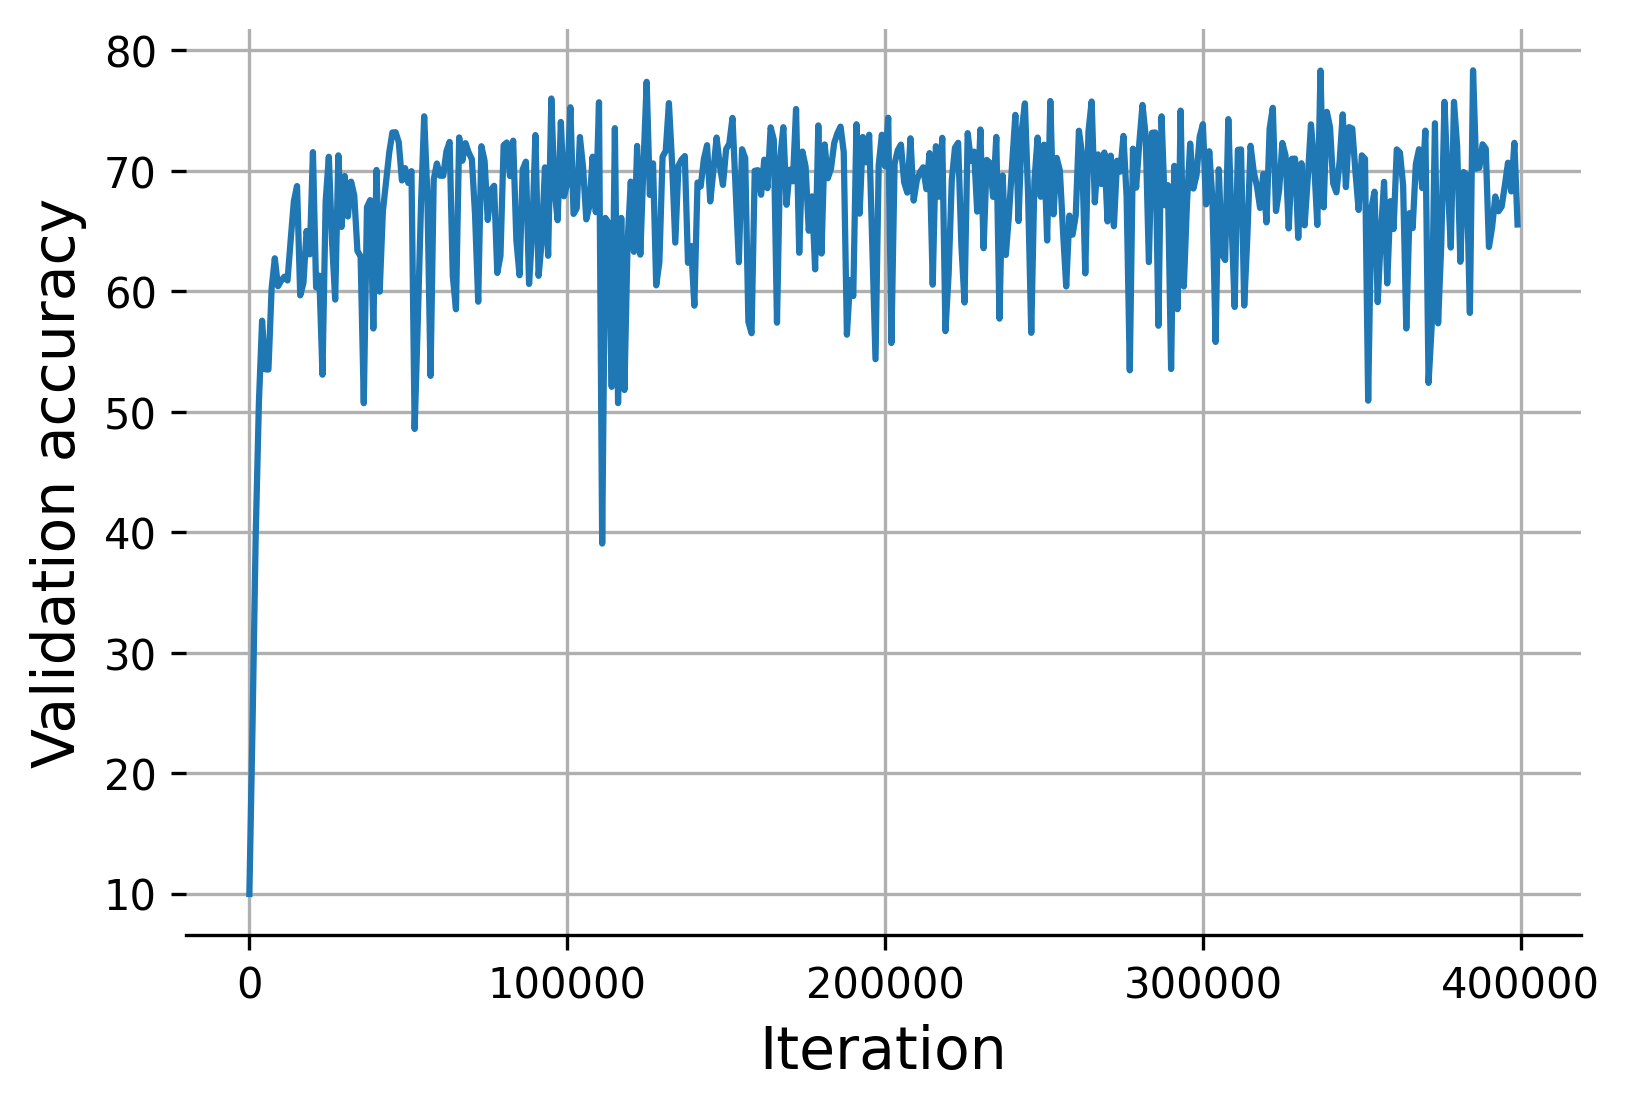

In [21]:
stats = np.load('Running Stats/stats_super.npz')
arr = stats['va']
print(arr.shape)
if arr.shape[0] == 40000:
    arr = arr[::100]
arr *= 100

x_values = np.arange(0, 400000, 1000)
x_pos = np.arange(0, 400001, 100000)
    
fig, ax = plt.subplots()
ax.plot(x_values, arr)
ax.set_ylabel('Validation accuracy', fontsize=14)
ax.set_xlabel('Iteration', fontsize=14)
ax.set_xticks(x_pos)
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid()
plt.show()

### Variable Labels Experiment

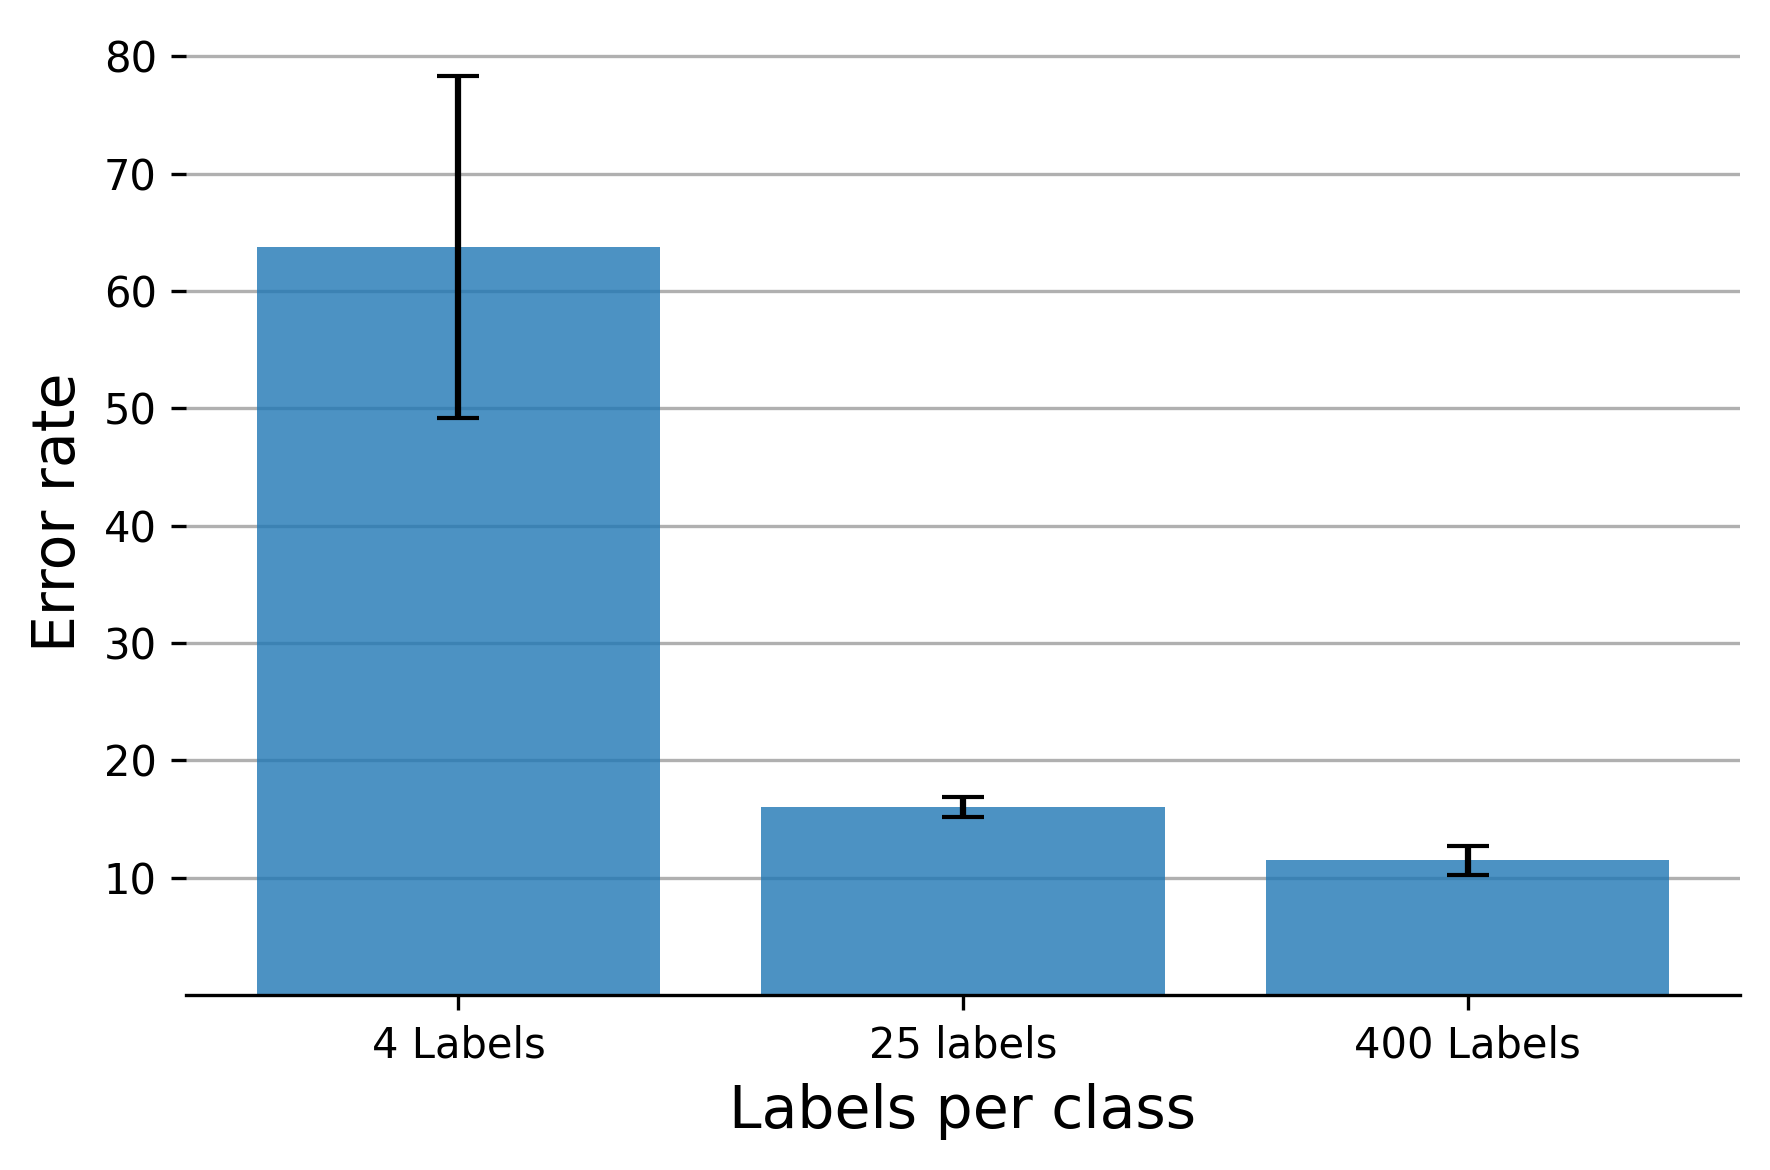

In [22]:
low_label_err = [64.61, 53.56, 63.25, 89.99, 47.32]
mid_label_err = [17.44, 15.59, 14.98, 15.55, 16.46]
high_label_err = [11.58, 10.32, 10.77, 10.96, 13.83]

low_label_err_mean = np.mean(low_label_err)
mid_label_err_mean = np.mean(mid_label_err)
high_label_err_mean = np.mean(high_label_err)
low_label_err_std = np.std(low_label_err)
mid_label_err_std = np.std(mid_label_err)
high_label_err_std = np.std(high_label_err)

label_amounts = ['4 Labels', '25 labels', '400 Labels']
x_pos = np.arange(len(label_amounts))
y_ticks = np.arange(80, 0, -10)
label_err_mean = [low_label_err_mean, mid_label_err_mean, high_label_err_mean]
std_dev = [low_label_err_std, mid_label_err_std, high_label_err_std]

fig, ax = plt.subplots()
ax.bar(x_pos,
       label_err_mean,
       yerr=std_dev,
       align='center',
       alpha=0.8,
       ecolor='black',
       capsize=5)
ax.set_ylabel('Error rate', fontsize=14)
ax.set_xlabel('Labels per class', fontsize=14)
ax.set_xticks(x_pos)
ax.set_yticks(y_ticks)
ax.set_xticklabels(label_amounts)
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Save the figure and show
plt.tight_layout()
plt.show()

### Weight Decay Ablation

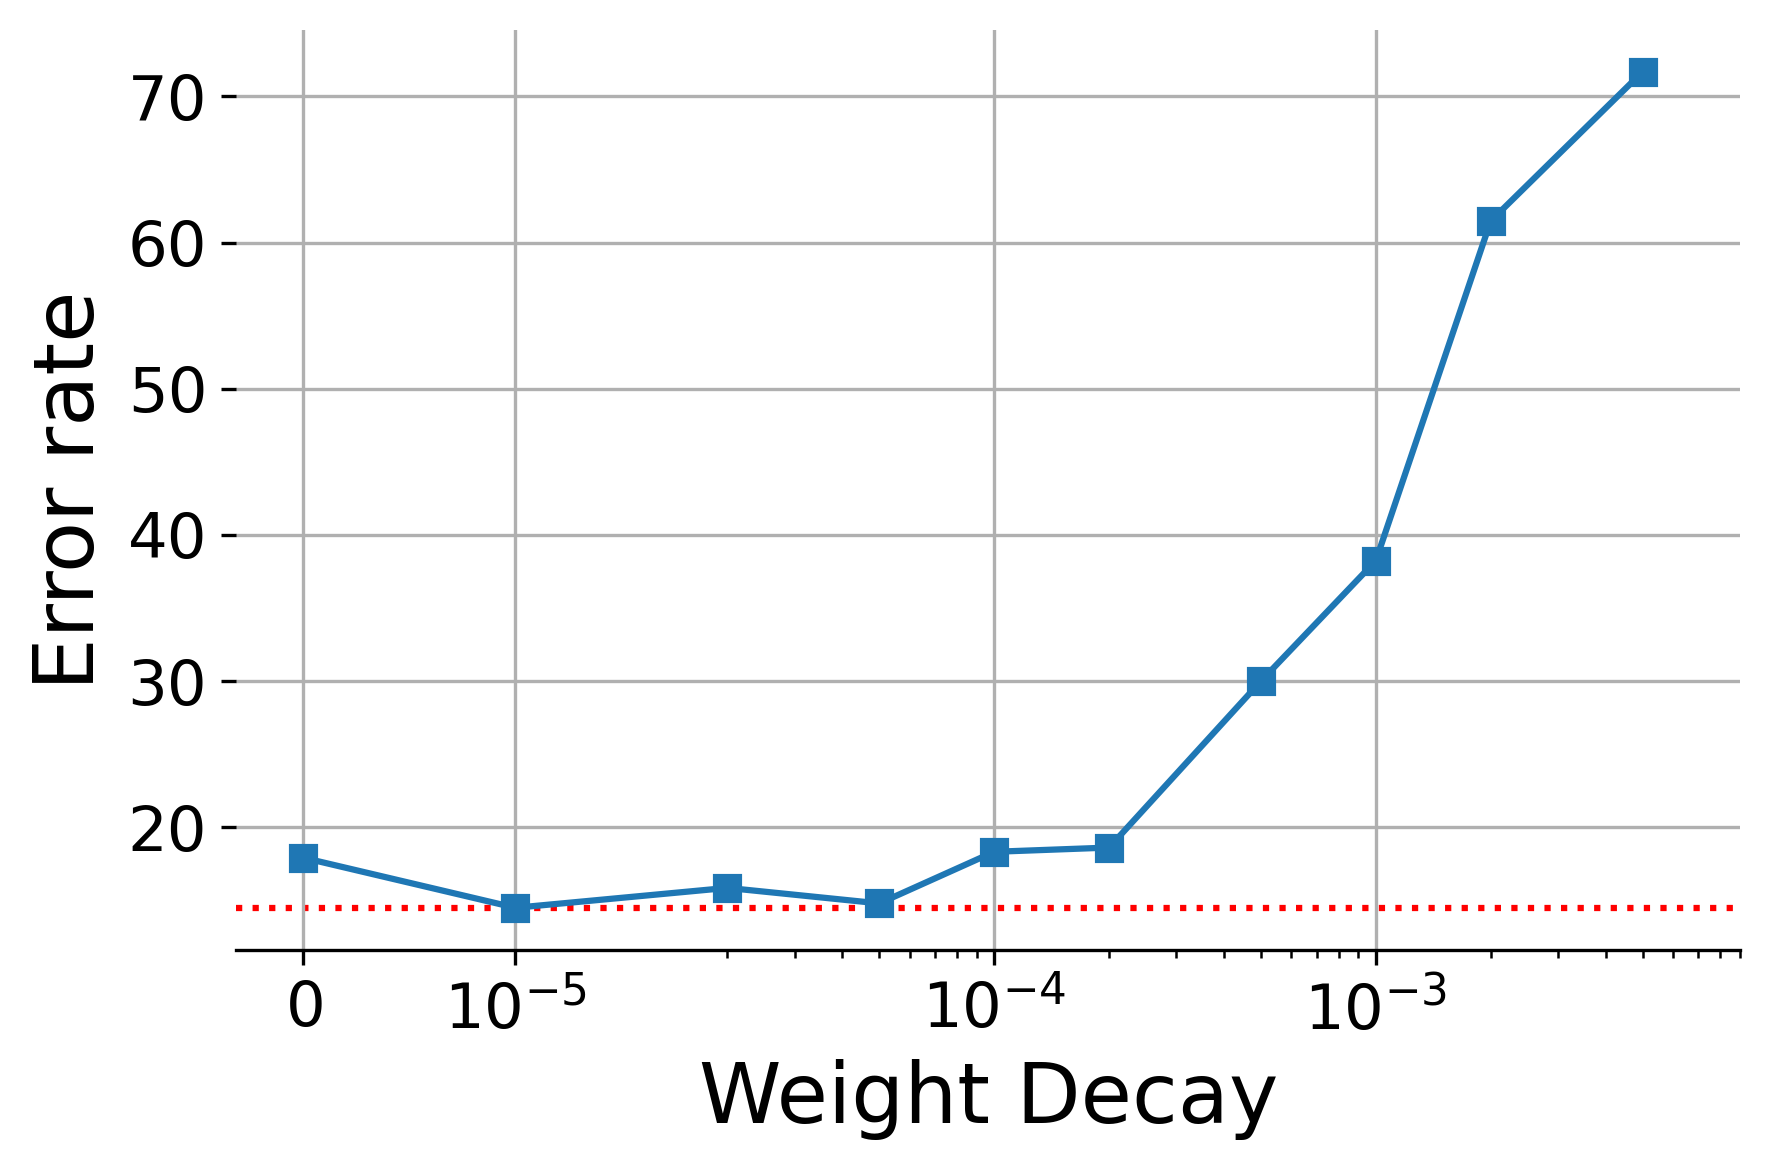

In [23]:
def tickrange(magnitudes):
    ticks = np.array([])
    for i in range(len(magnitudes) - 1):
        ticks = np.concatenate(
            (ticks, np.arange(magnitudes[i], magnitudes[i + 1],
                              magnitudes[i])))
    return ticks

wd_ablation = [
    17.91, 14.49, 15.85, 14.79, 18.32, 18.61, 30.00, 38.24, 61.48, 71.69
]
wd_ablation_values = [
    0, 0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005
]

fig1, ax1 = plt.subplots()
ax1.plot(wd_ablation_values, wd_ablation, marker='s')
ax1.set_xscale('symlog', linthreshx=0.00002)
ax1.set_ylabel('Error rate', fontsize=20)
ax1.set_xlabel('Weight Decay', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.axhline(y=min(wd_ablation),
            xmin=0,
            xmax=1,
            color='red',
            linestyle=':',
            zorder=1)
ax1.set_xticks(tickrange([0.00001, 0.0001, 0.001, 0.01]), minor=True)
plt.grid()
plt.tight_layout()
plt.show()

### Mu Ablation

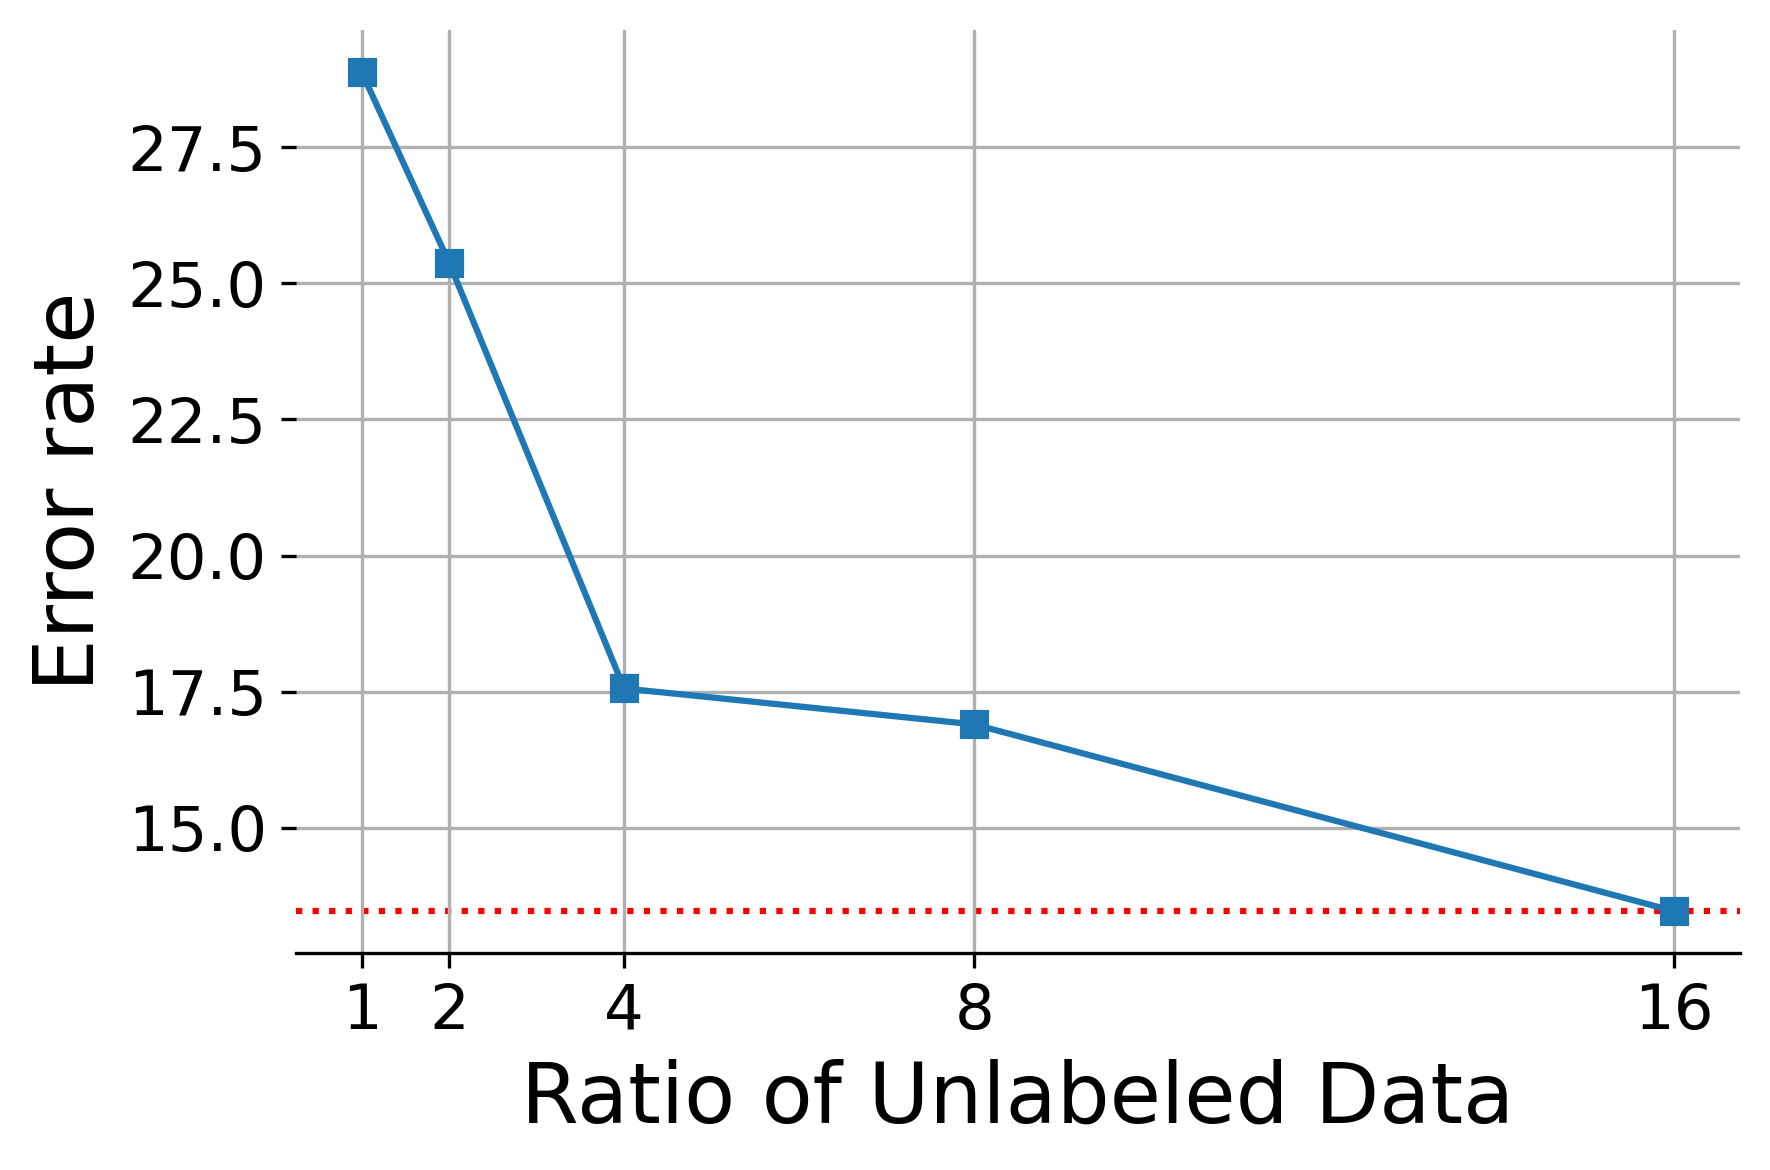

In [24]:
mu_ablation = [28.88, 25.38, 17.56, 16.90, 13.47]
mu_ablation_values = [1, 2, 4, 8, 16]

fig1, ax1 = plt.subplots()
ax1.plot(mu_ablation_values, mu_ablation, marker='s')
ax1.set_ylabel('Error rate', fontsize=20)
ax1.set_xlabel('Ratio of Unlabeled Data', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.axhline(y=min(mu_ablation),
            xmin=0,
            xmax=1,
            color='red',
            linestyle=':',
            zorder=1)
plt.grid()
plt.xticks(2 ** np.arange(5))
plt.tight_layout()
plt.show()

### Lambda Ablation

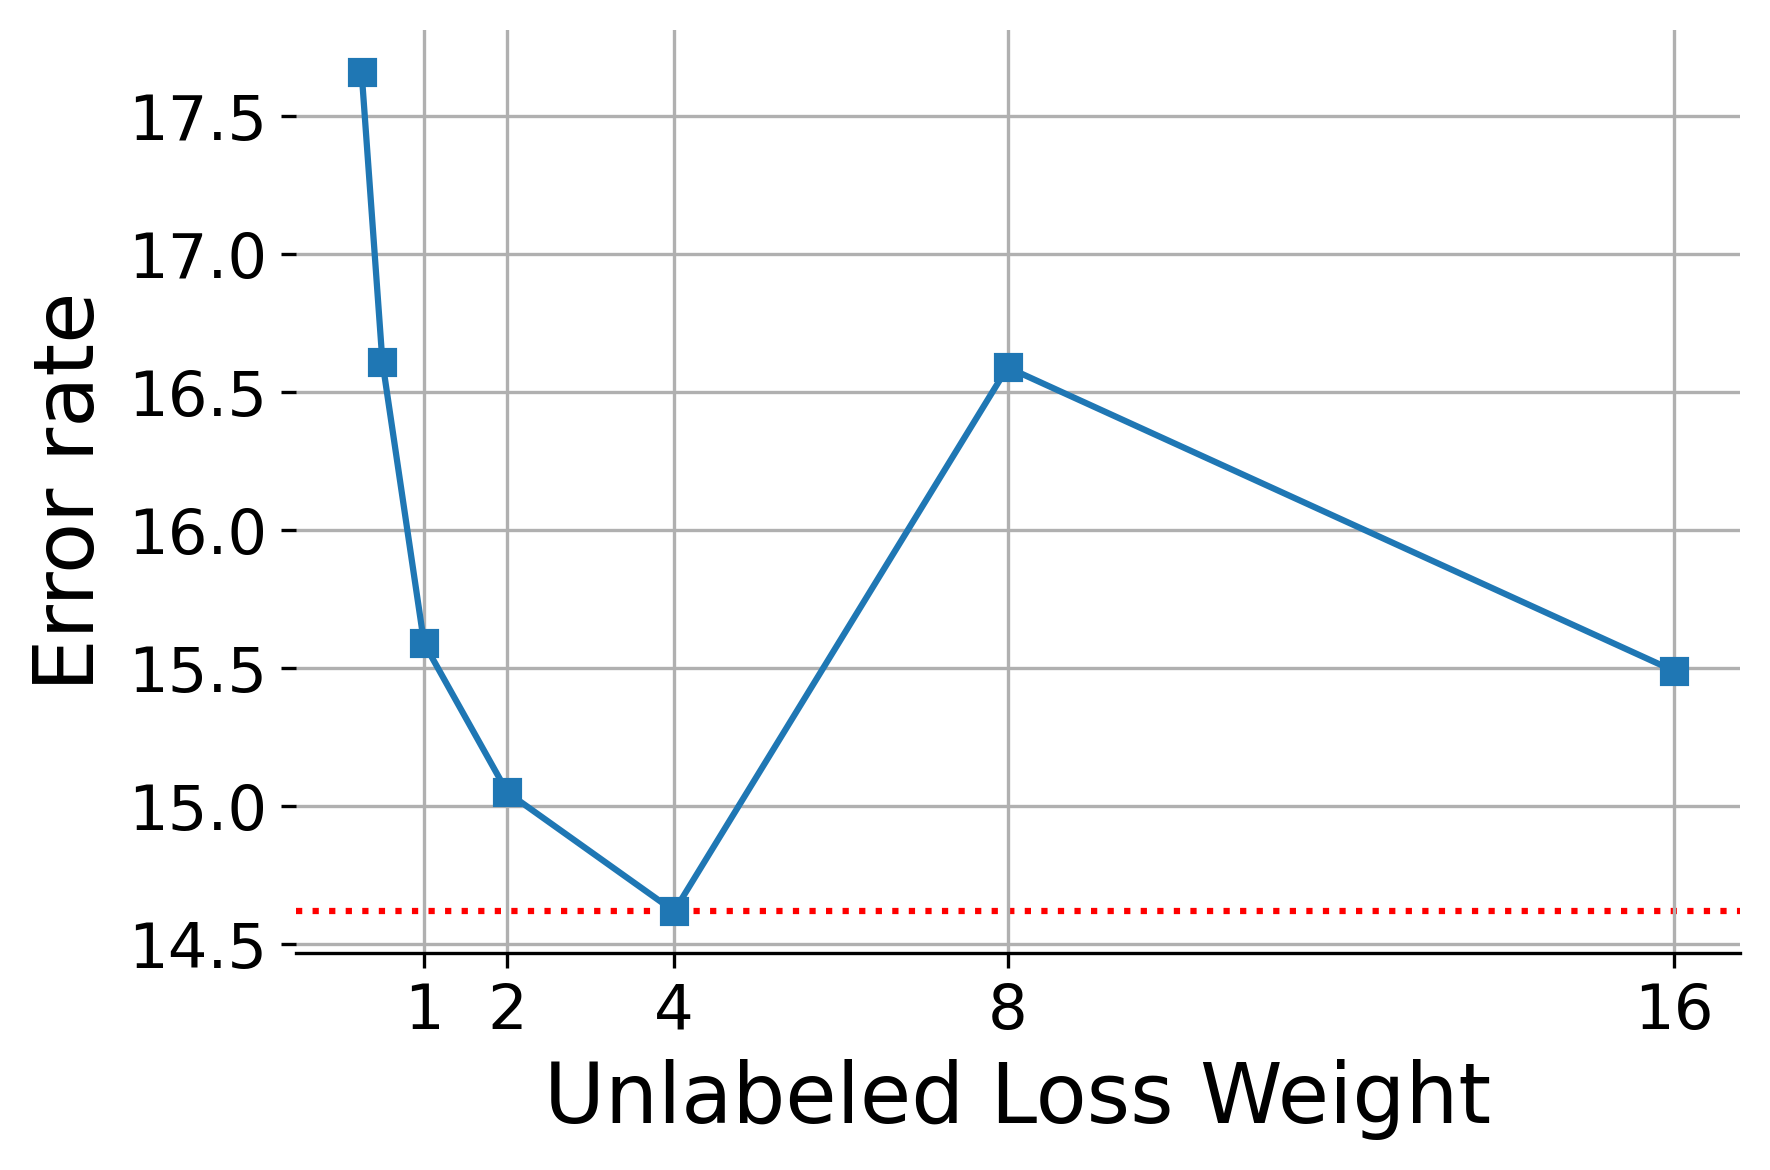

In [25]:
lambda_ablation = [17.66, 16.61, 15.59, 15.05, 14.62, 16.59, 15.49]
lambda_ablation_values = [0.25, 0.5, 1, 2, 4, 8, 16]

fig1, ax1 = plt.subplots()
ax1.plot(lambda_ablation_values, lambda_ablation, marker='s')
ax1.set_ylabel('Error rate', fontsize=20)
ax1.set_xlabel('Unlabeled Loss Weight', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.axhline(y=min(lambda_ablation),
            xmin=0,
            xmax=1,
            color='red',
            linestyle=':',
            zorder=1)
plt.grid()
plt.xticks(2 ** np.arange(5))
plt.tight_layout()
plt.show()

### Augmentation Effect

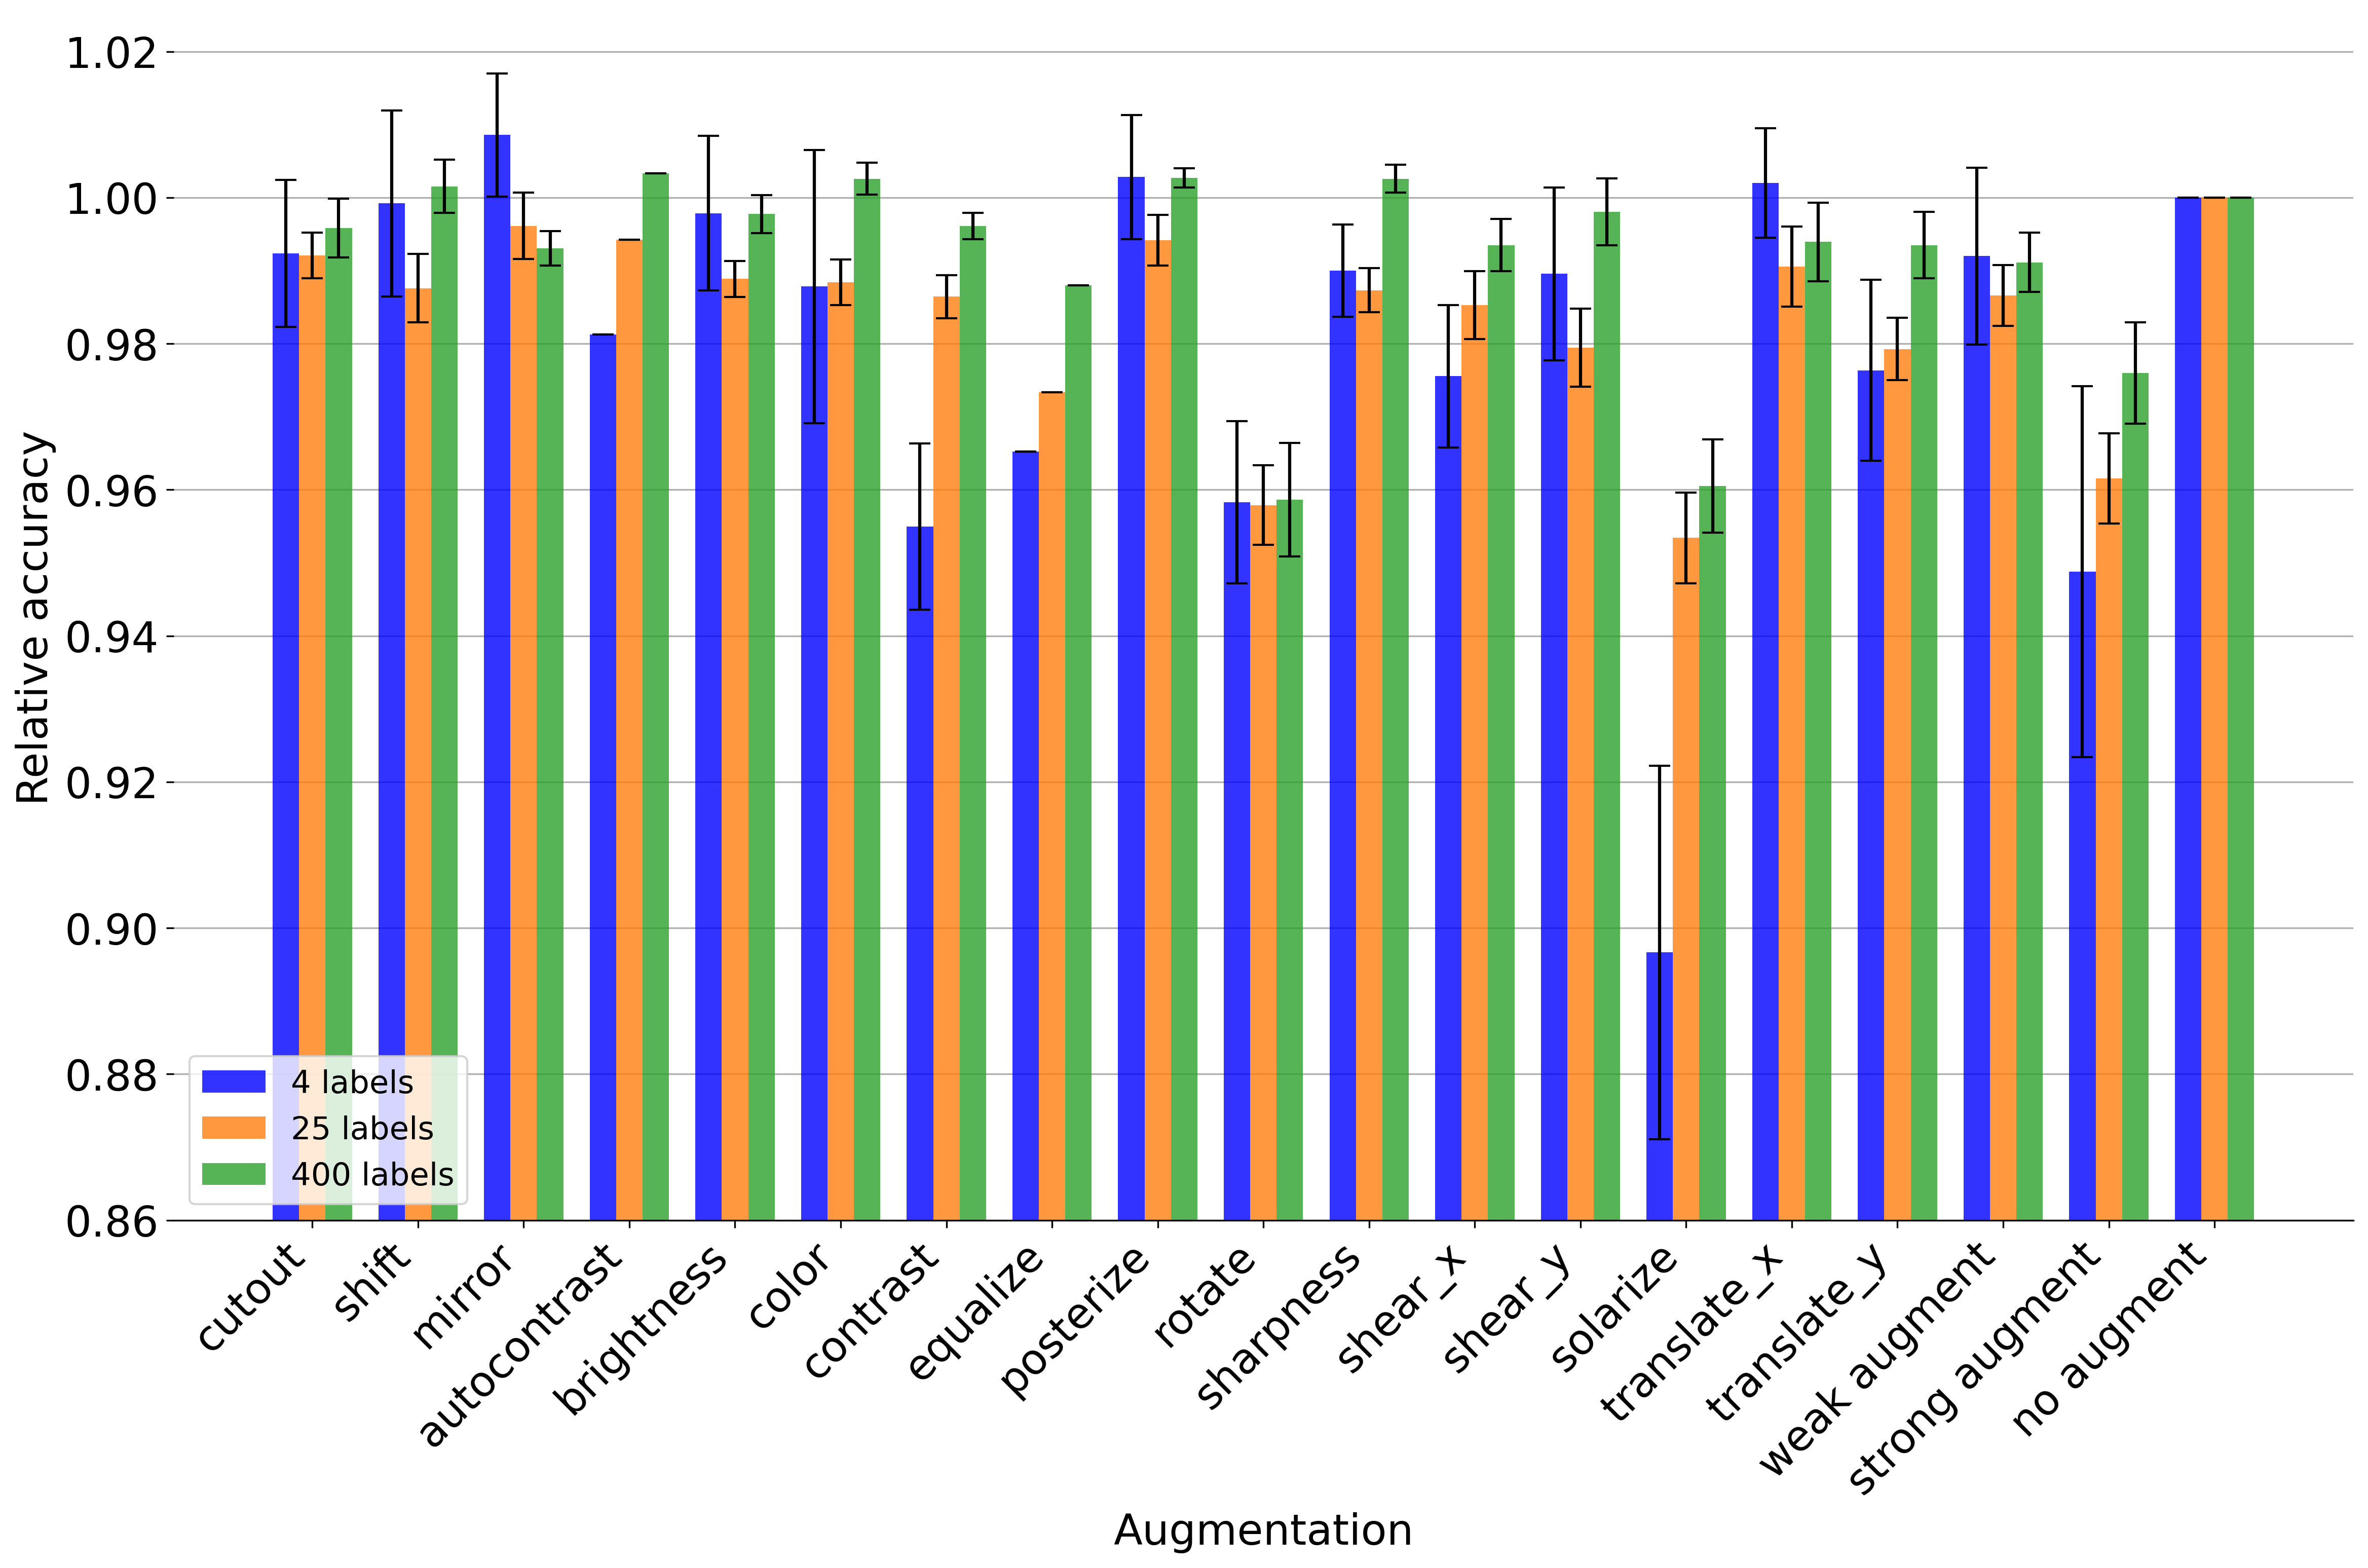

In [28]:
labels = [
    'cutout', 'shift', 'mirror', 'autocontrast', 'brightness', 'color',
    'contrast', 'equalize', 'posterize', 'rotate', 'sharpness', 'shear_x',
    'shear_y', 'solarize', 'translate_x', 'translate_y', 'weak augment',
    'strong augment', 'no augment'
]

x_pos = np.arange(len(labels))

width = 0.25

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.bar(x_pos - width,
       aug_effect_mean[0],
       yerr=aug_effect_std[0],
       width=width,
       color='b',
       align='center',
       alpha=0.8,
       ecolor='black',
       capsize=5,
       label='4 labels')
ax.bar(x_pos,
       aug_effect_mean[1],
       yerr=aug_effect_std[1],
       width=width,
       color='tab:orange',
       align='center',
       alpha=0.8,
       ecolor='black',
       capsize=5,
       label='25 labels')
ax.bar(x_pos + width,
       aug_effect_mean[2],
       yerr=aug_effect_std[2],
       width=width,
       color='tab:green',
       align='center',
       alpha=0.8,
       ecolor='black',
       capsize=5,
       label='400 labels')
ax.set_ylabel('Relative accuracy', fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_xlabel('Augmentation', fontsize=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=45, fontsize=20, ha='right')
ax.set_axisbelow(True)
ax.yaxis.grid(True)
ax.set_ylim(0.86, 1.025)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(fontsize=15, loc='lower left')

# Save the figure and show
#plt.tight_layout()
plt.show()

## Grad-CAM

In [29]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:
            return layer
    raise ValueError("Could not find conv layer. Cannot apply GradCAM.")


def make_gradcam_heatmap(images_array, model):
    last_conv_layer = find_last_conv_layer(model)

    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    after_last_conv = False
    classifier_layer_names = []
    for layer in model.layers:
        if after_last_conv:
            classifier_layer_names.append(layer.name)
        elif find_last_conv_layer(model).name == layer.name:
            after_last_conv = True

    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(images_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds, axis=1)
        one_hot_mask = tf.one_hot(
            top_pred_index,
            preds.shape[1],
            on_value=True,
            off_value=False,
            dtype=tf.bool,
        )
        top_class_channel = tf.boolean_mask(preds, one_hot_mask)

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[0]):
        for j in range(pooled_grads.shape[-1]):
            last_conv_layer_output[i, :, :, j] *= pooled_grads[i, j]

    heatmap = np.mean(last_conv_layer_output, axis=-1)

    max_heatmap = np.maximum(heatmap, 0)
    for i in range(pooled_grads.shape[0]):
        heatmap[i] = max_heatmap[i] / np.max(heatmap[i])

    return heatmap


def combine_heatmap_image(image_array, heatmap):
    image_array = np.uint8(255 * image_array)
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]

    superimposed_imgs = np.zeros(image_array.shape)
    for i, (hm, im) in enumerate(zip(heatmap, image_array)):
        jet_heatmap = jet_colors[hm]

        jet_heatmap = array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize(
            (image_array.shape[1], image_array.shape[2]))
        jet_heatmap = img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * 0.4 + im
        superimposed_img = array_to_img(superimposed_img)
        superimposed_imgs[i] = superimposed_img

    return superimposed_imgs / 255

### Grad-CAM Experiments

In [30]:
model1 = load_model('25_1')
model2 = load_model('25_2')
model3 = load_model('25_3')
model4 = load_model('25_4')
model5 = load_model('25_5')

(test_grad,
 n_test_grad_batches) = dataset_test_gradcam_fixed(10,
                                                   100,
                                                   identity,
                                                   rotate,
                                                   augment_image_strong,
                                                   do_cutout=False,
                                                   shuffle_classes=True)

In [31]:
skip = 0

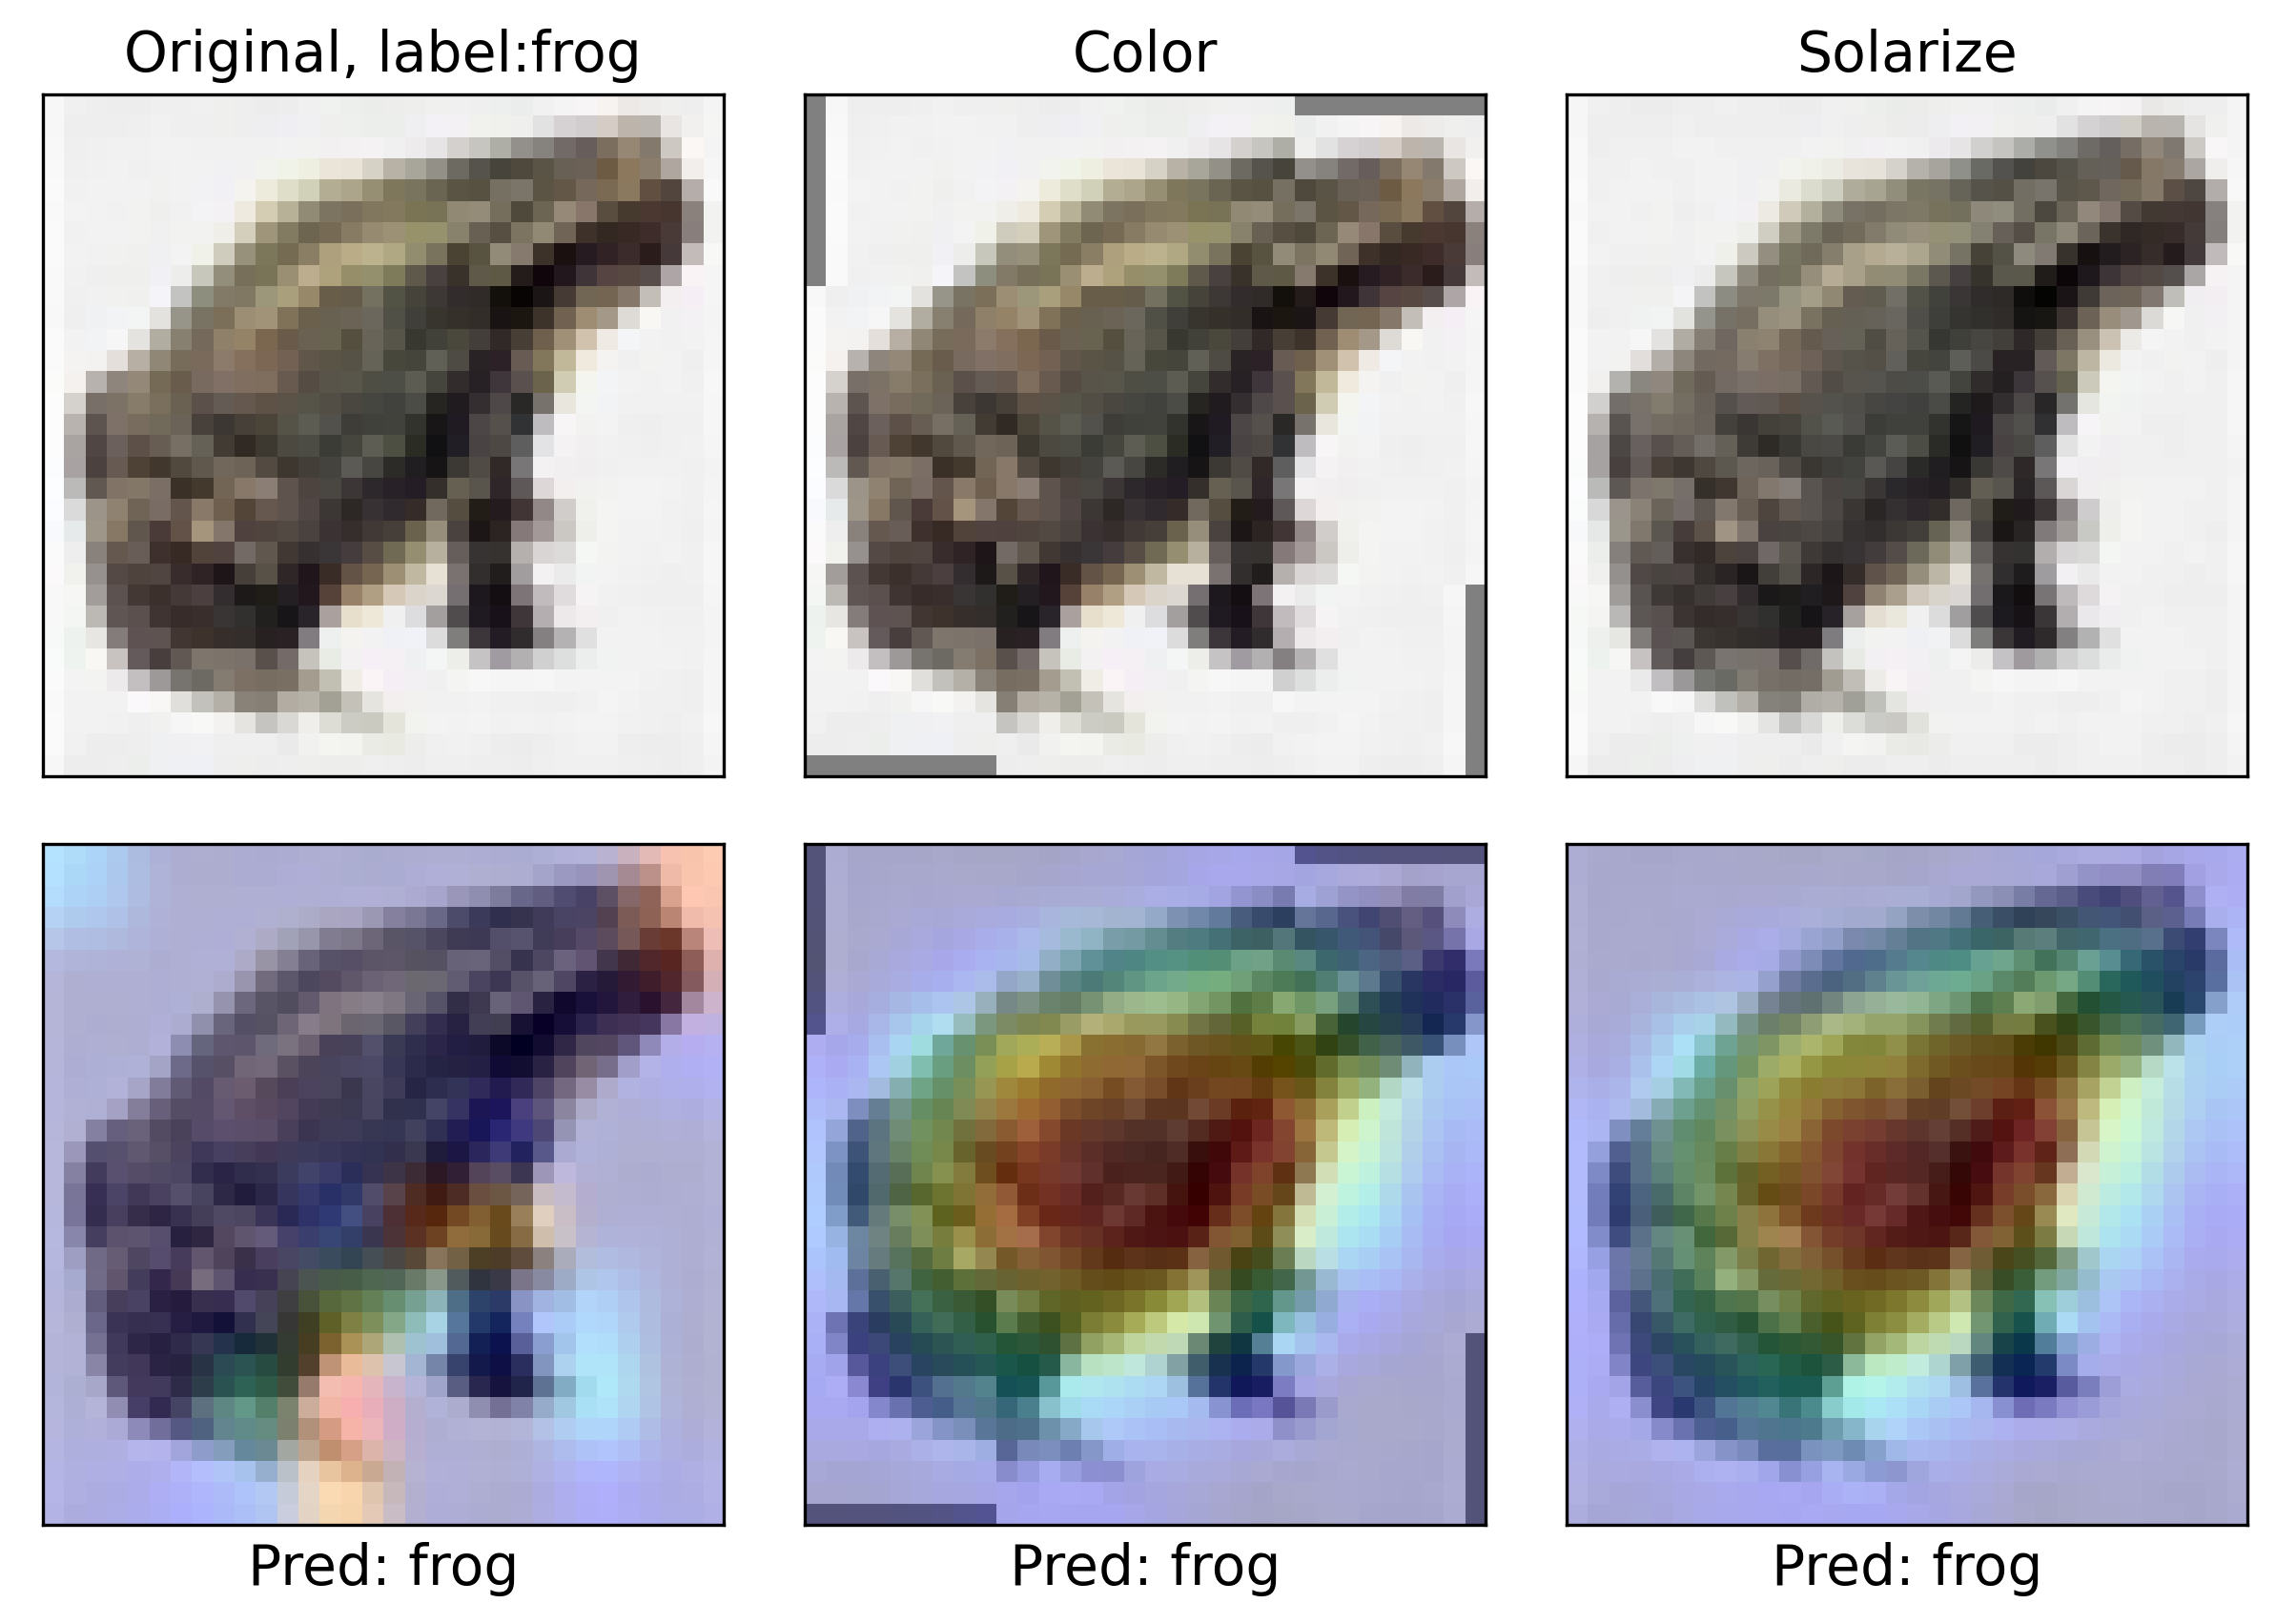

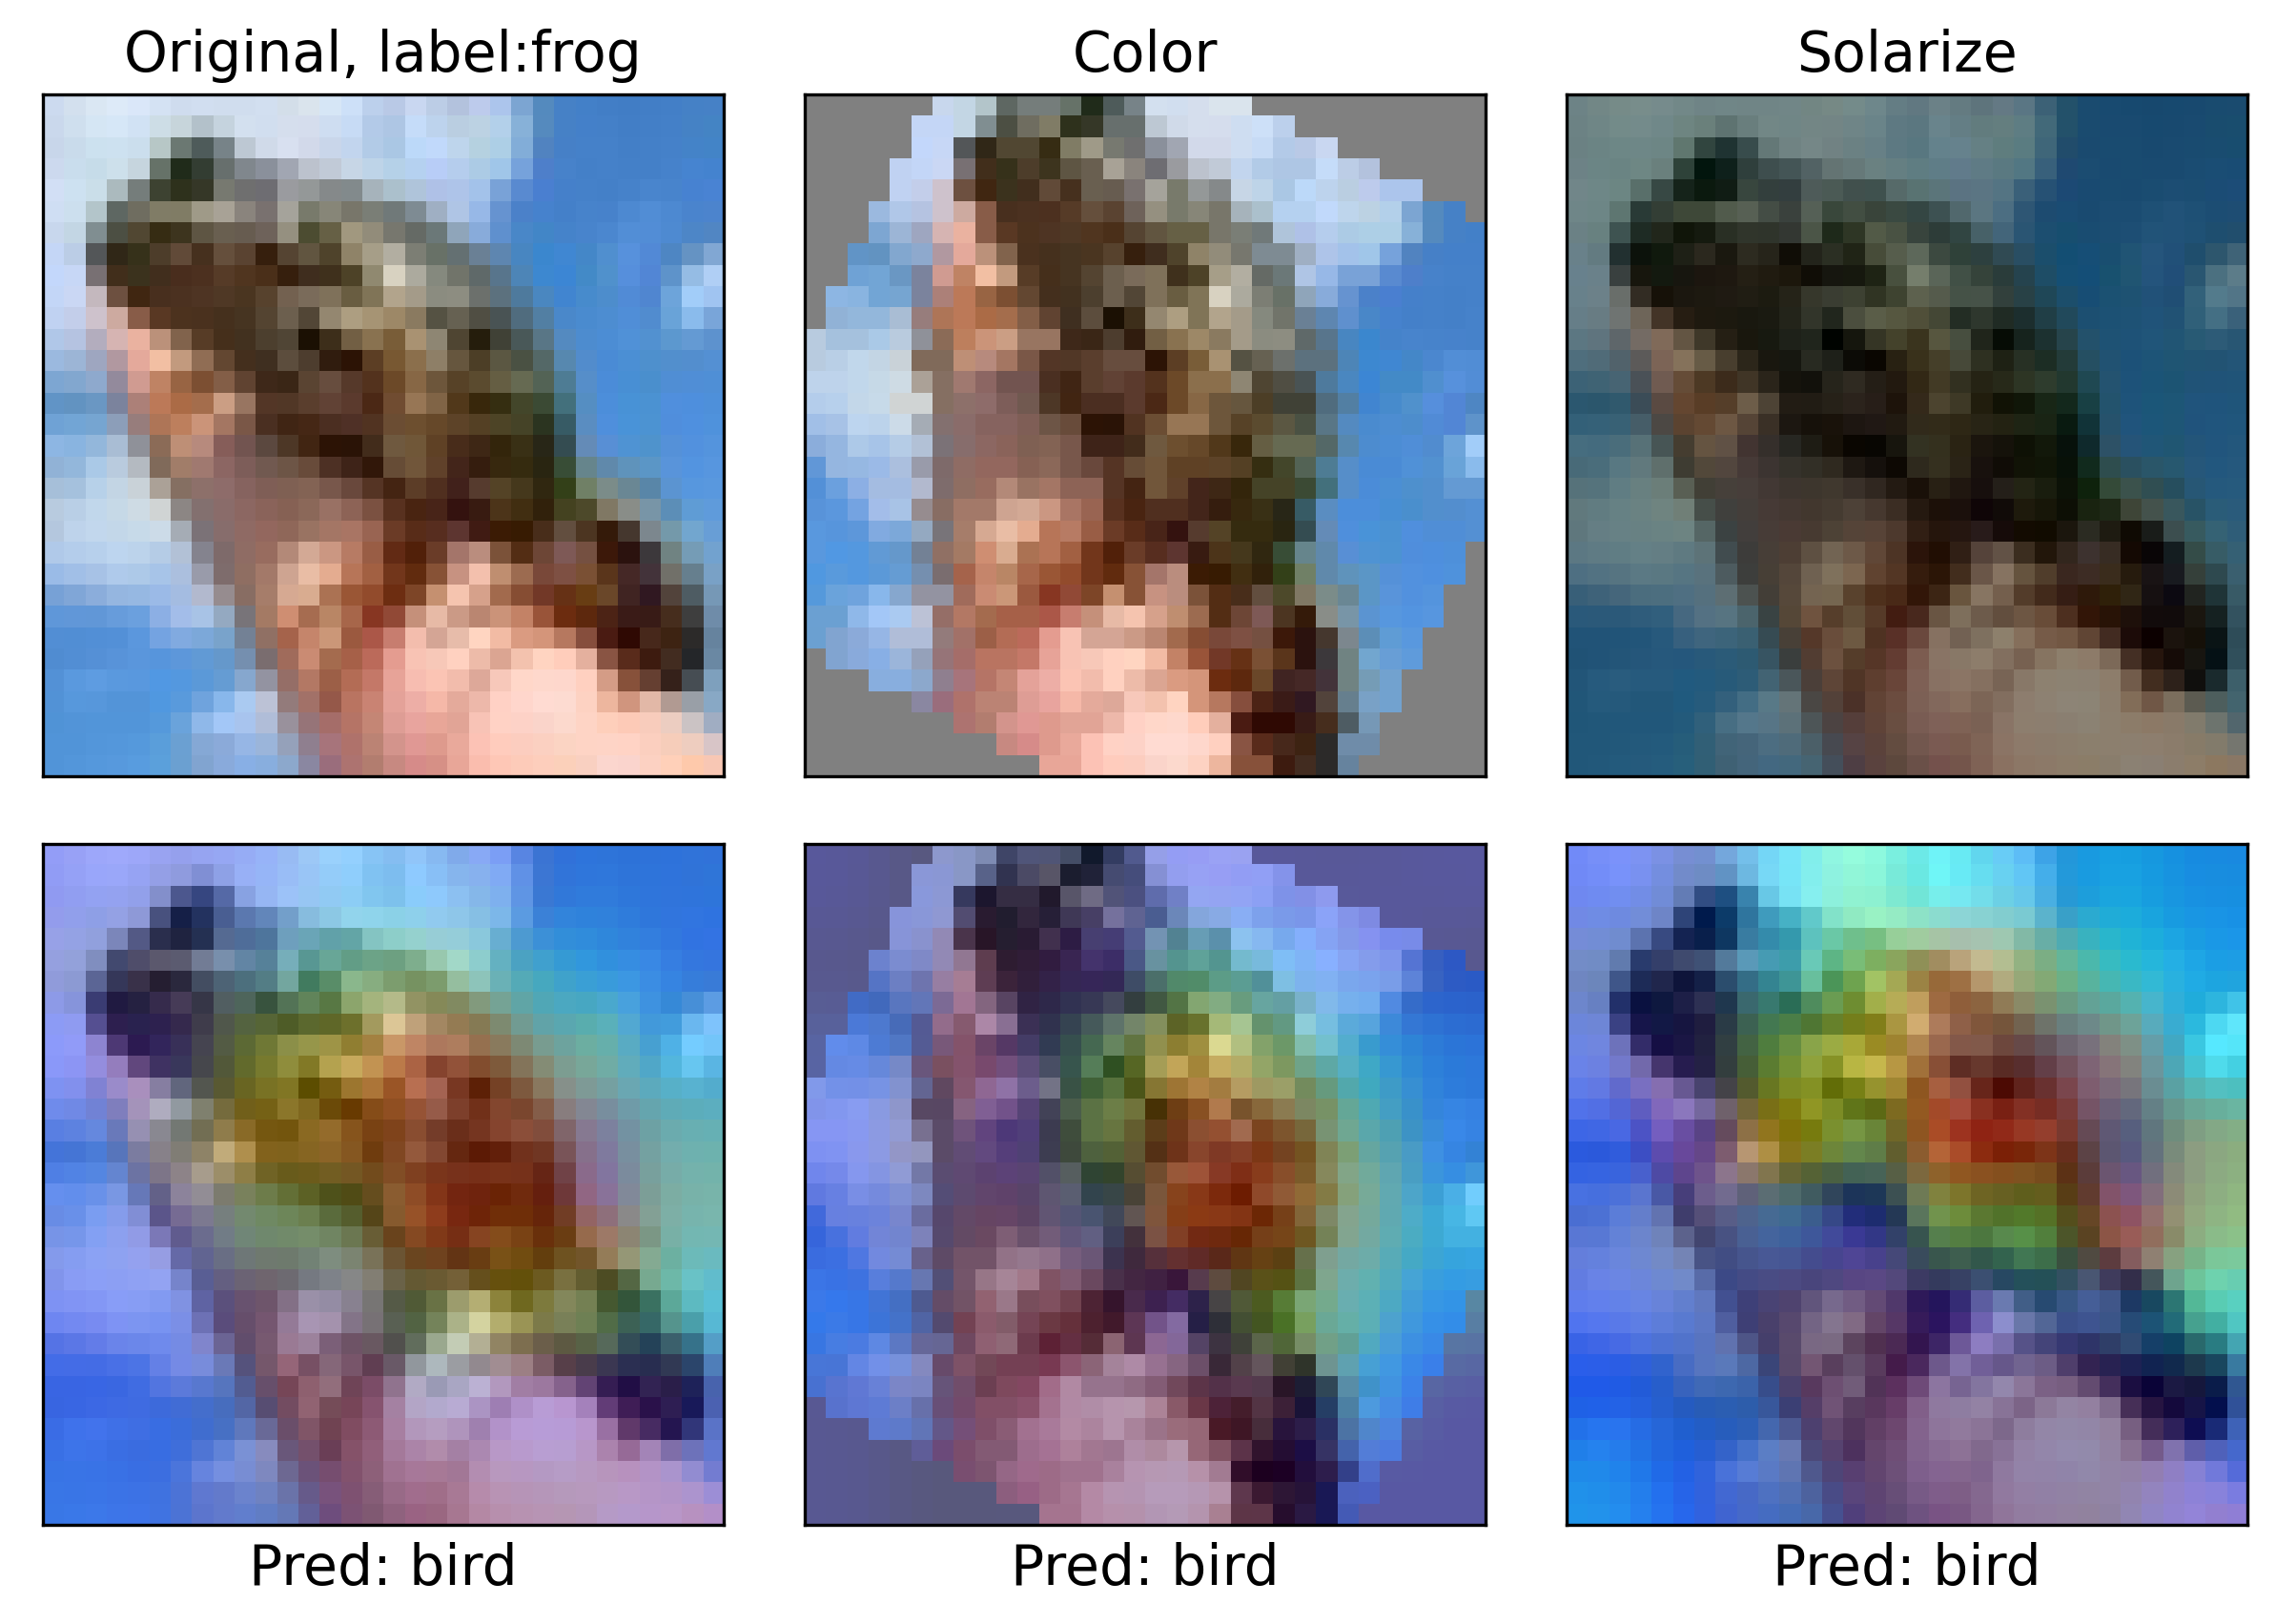

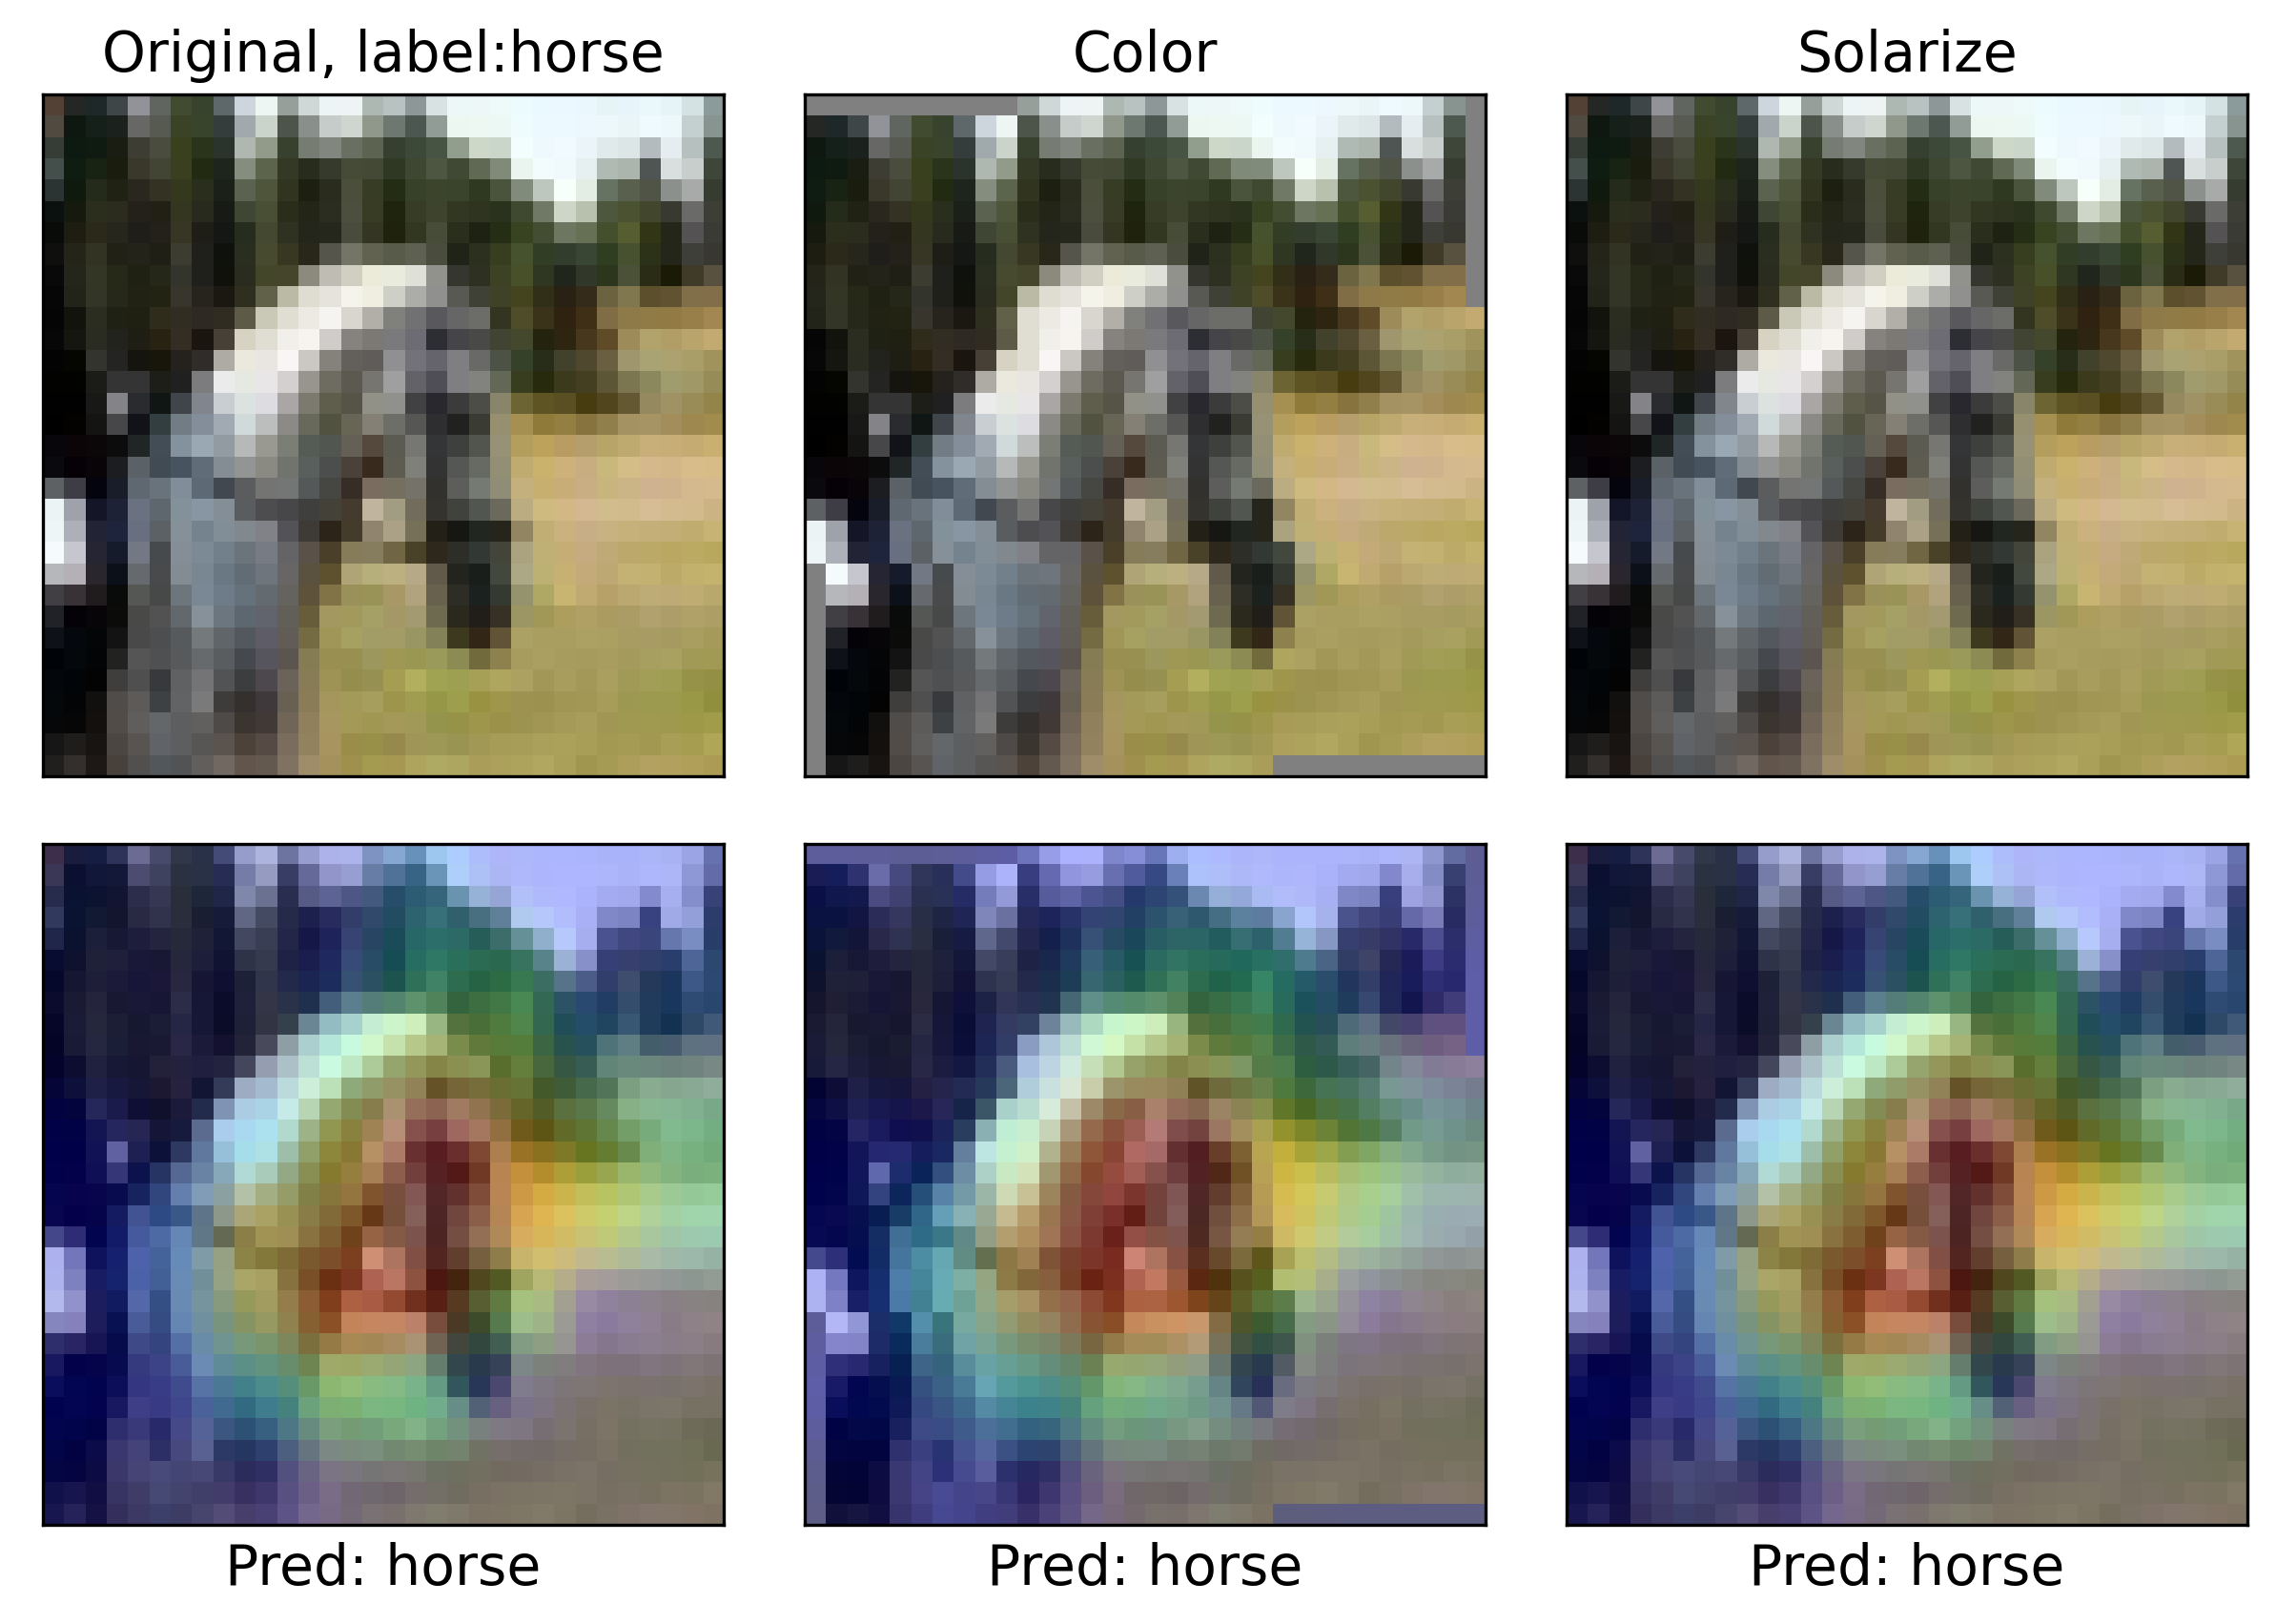

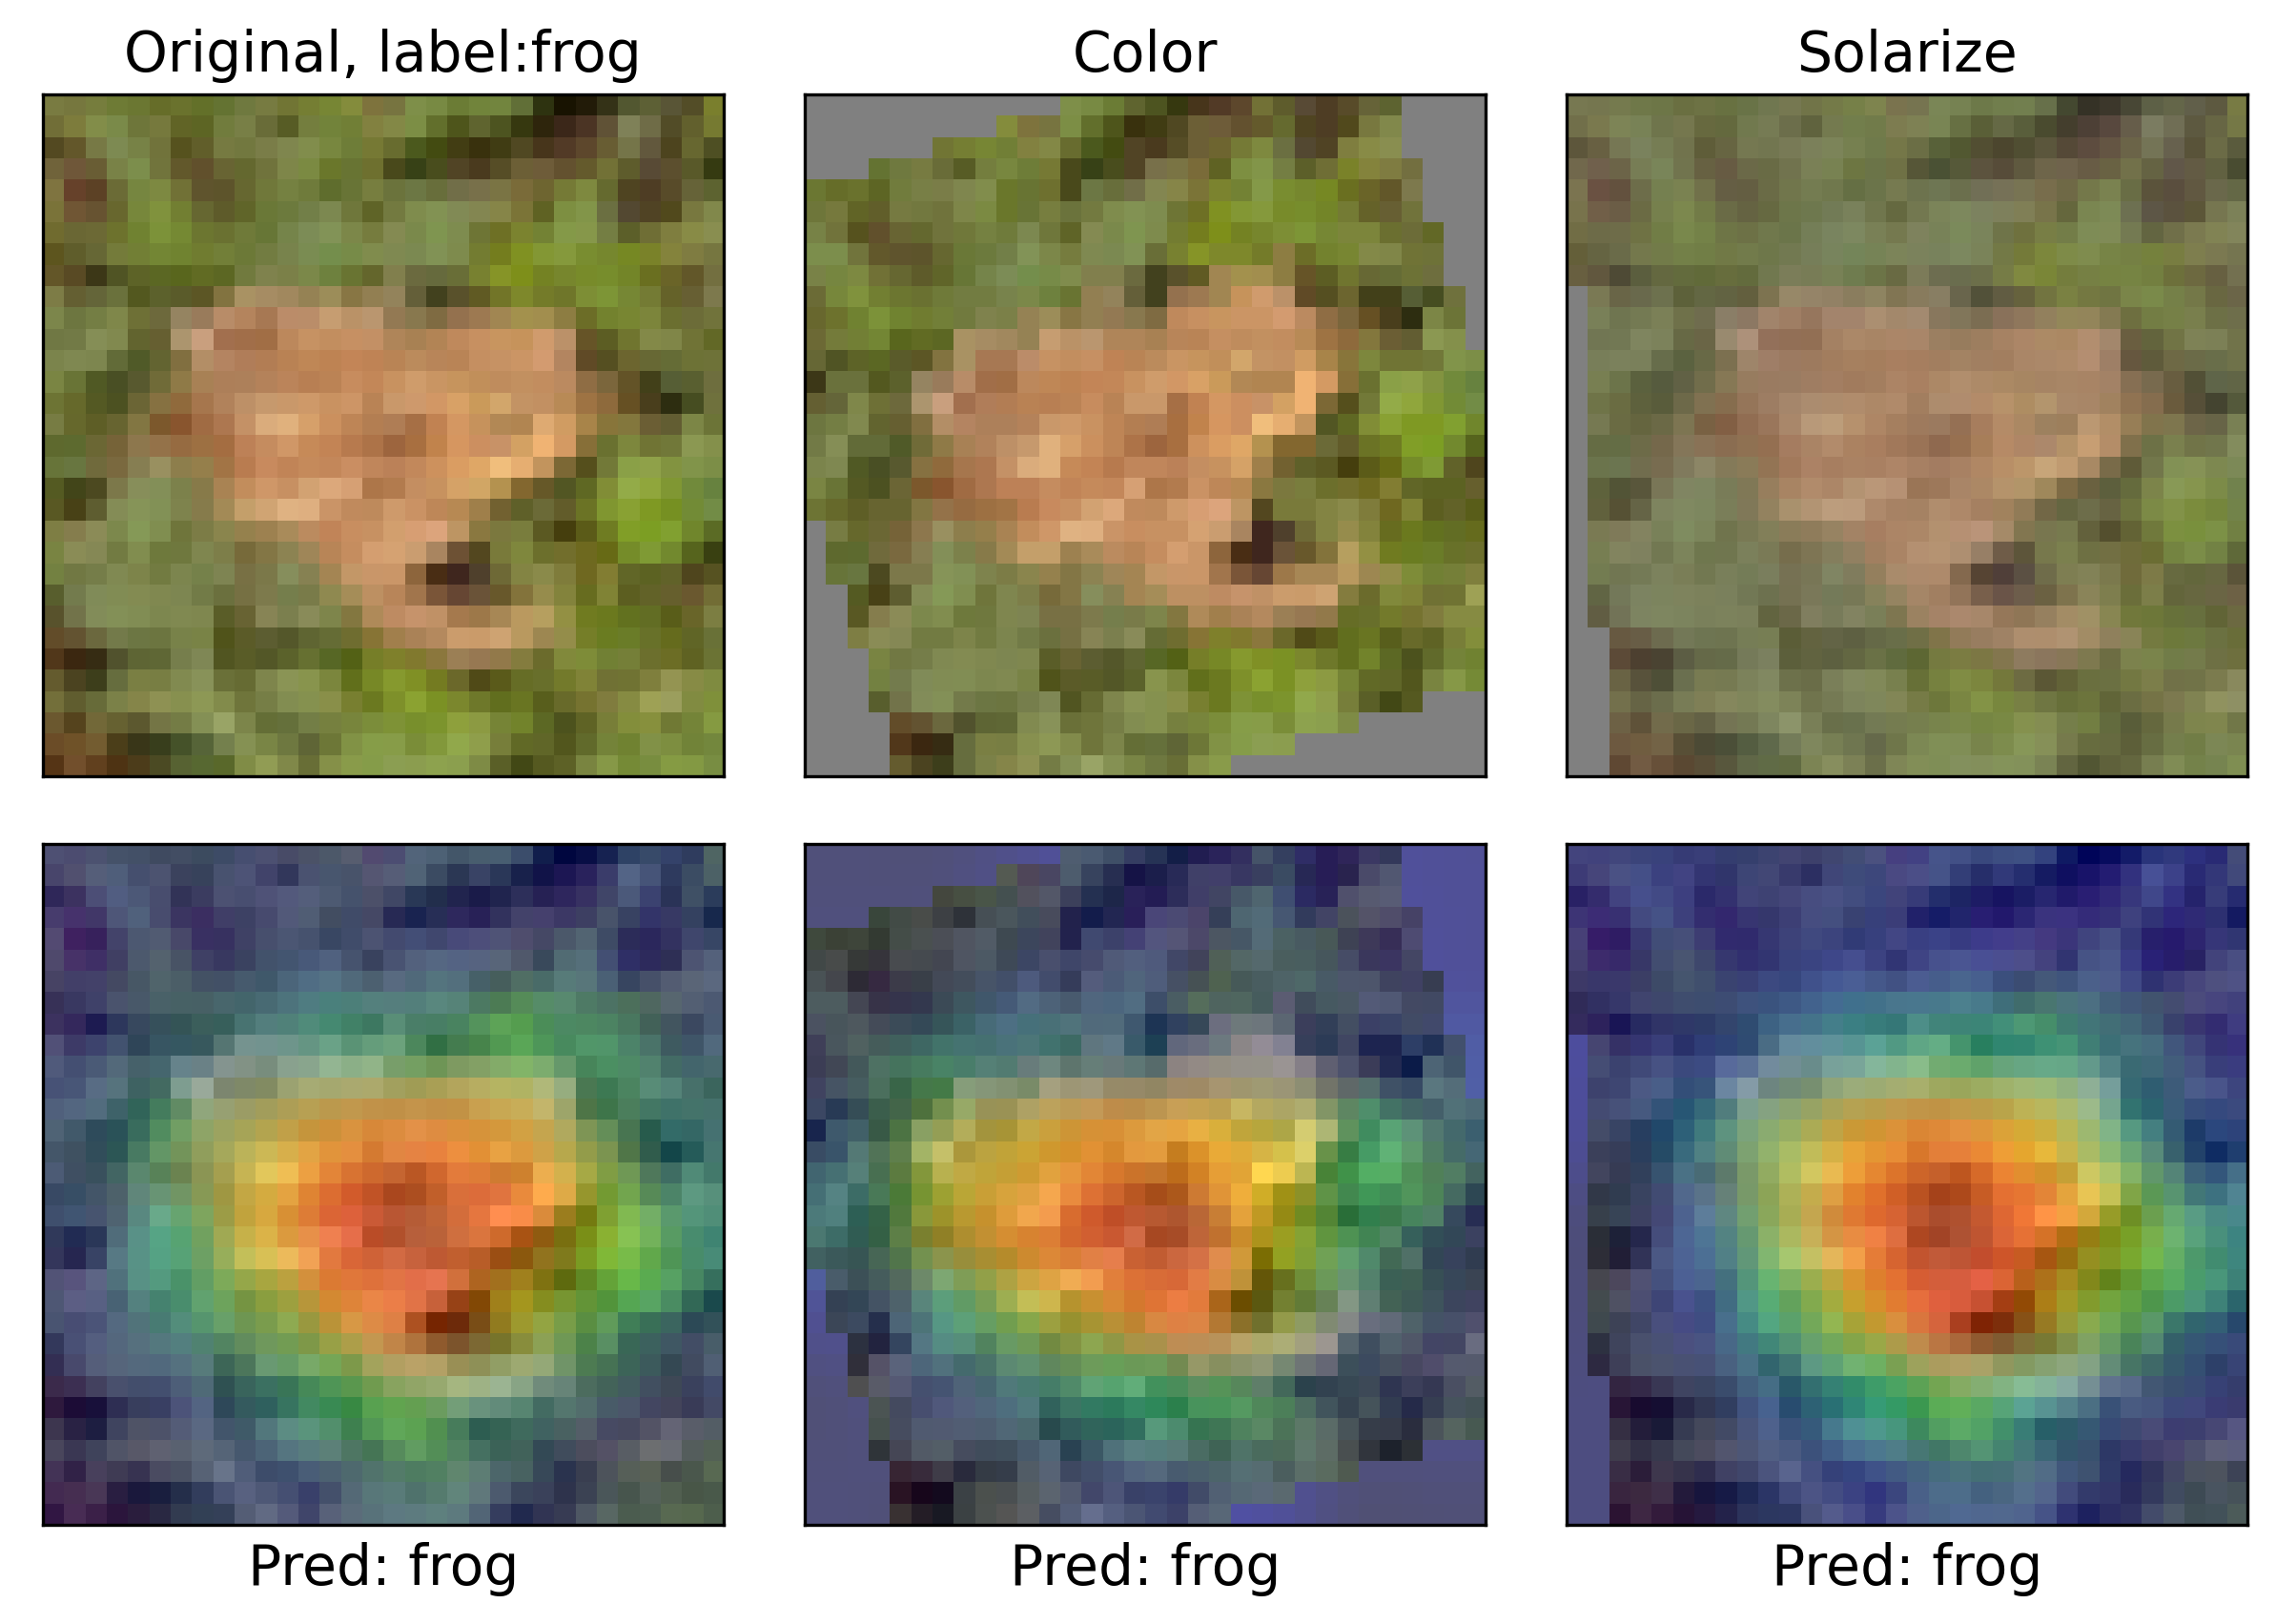

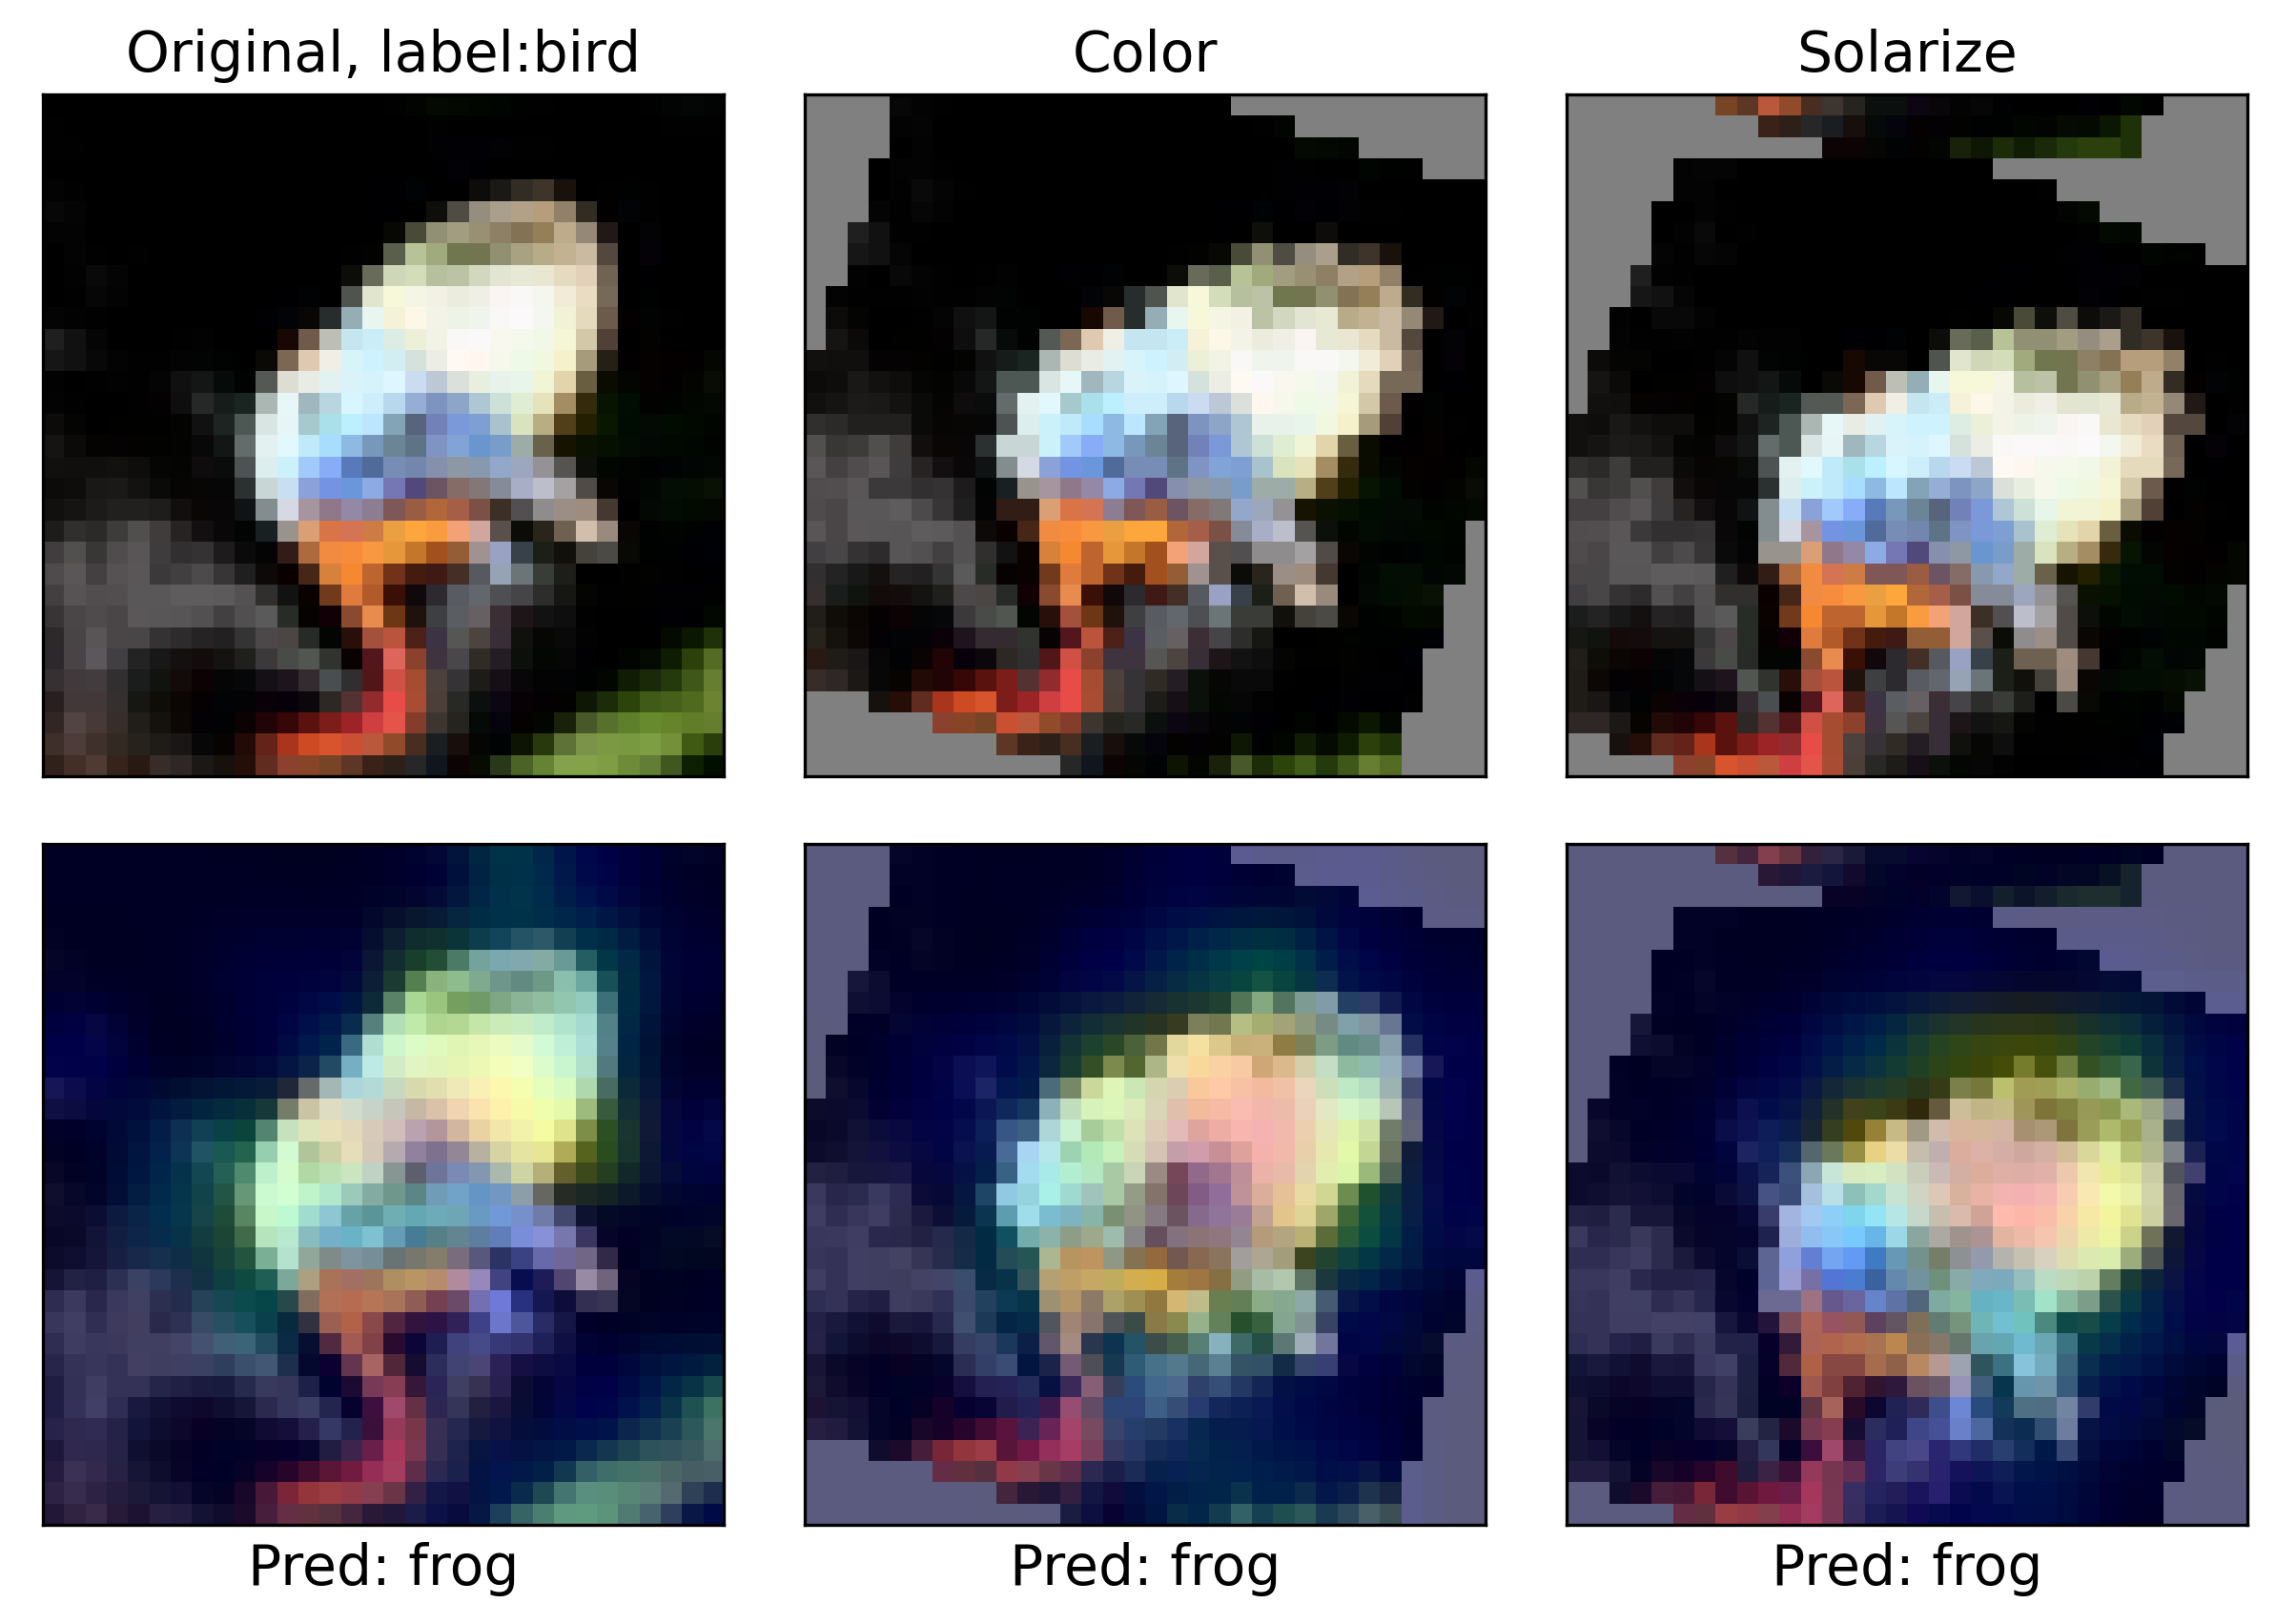

In [32]:
it = iter(
    tfds.as_numpy(test_grad.unbatch().batch(1).skip(skip).take(5).repeat()))

classes = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
    "ship", "truck"
]

for i in range(5):
    (c_a, w_a, s_a, labels) = next(it)
    heatmap_c = make_gradcam_heatmap(c_a, model)
    heatmap_w = make_gradcam_heatmap(w_a, model)
    heatmap_s = make_gradcam_heatmap(s_a, model)
    heatmap_c_img = combine_heatmap_image(c_a, heatmap_c)
    heatmap_w_img = combine_heatmap_image(w_a, heatmap_w)
    heatmap_s_img = combine_heatmap_image(s_a, heatmap_s)

    f, axarr = plt.subplots(2, 3, figsize=(10, 10))
    plt.subplots_adjust(left=0.125,
                        bottom=0.1,
                        right=0.9,
                        top=0.6,
                        wspace=0.1,
                        hspace=0.1)
    axarr[0, 0].imshow(c_a[0])
    axarr[0, 0].set_title('Original, label:' + classes[np.argmax(labels[0])], fontsize=14)
    axarr[0, 0].set_xticks([])
    axarr[0, 0].set_xticks([], minor=True)
    axarr[0, 0].set_yticks([])
    axarr[0, 0].set_yticks([], minor=True)

    axarr[0, 1].imshow(w_a[0])
    axarr[0, 1].set_title('Color', fontsize=14)
    axarr[0, 1].set_xticks([])
    axarr[0, 1].set_xticks([], minor=True)
    axarr[0, 1].set_yticks([])
    axarr[0, 1].set_yticks([], minor=True)

    axarr[0, 2].imshow(s_a[0])
    axarr[0, 2].set_title('Solarize', fontsize=14)
    axarr[0, 2].set_xticks([])
    axarr[0, 2].set_xticks([], minor=True)
    axarr[0, 2].set_yticks([])
    axarr[0, 2].set_yticks([], minor=True)

    axarr[1, 0].imshow(heatmap_c_img[0])
    axarr[1,
          0].set_xlabel('Pred: ' + classes[np.argmax(model(c_a), axis=1)[0]],
                        fontsize=14)
    axarr[1, 0].set_xticks([])
    axarr[1, 0].set_xticks([], minor=True)
    axarr[1, 0].set_yticks([])
    axarr[1, 0].set_yticks([], minor=True)

    axarr[1, 1].imshow(heatmap_w_img[0])
    axarr[1,
          1].set_xlabel('Pred: ' + classes[np.argmax(model(w_a), axis=1)[0]],
                        fontsize=14)
    axarr[1, 1].set_xticks([])
    axarr[1, 1].set_xticks([], minor=True)
    axarr[1, 1].set_yticks([])
    axarr[1, 1].set_yticks([], minor=True)

    axarr[1, 2].imshow(heatmap_s_img[0])
    axarr[1,
          2].set_xlabel('Pred: ' + classes[np.argmax(model(s_a), axis=1)[0]],
                        fontsize=14)
    axarr[1, 2].set_xticks([])
    axarr[1, 2].set_xticks([], minor=True)
    axarr[1, 2].set_yticks([])
    axarr[1, 2].set_yticks([], minor=True)

    skip += 5

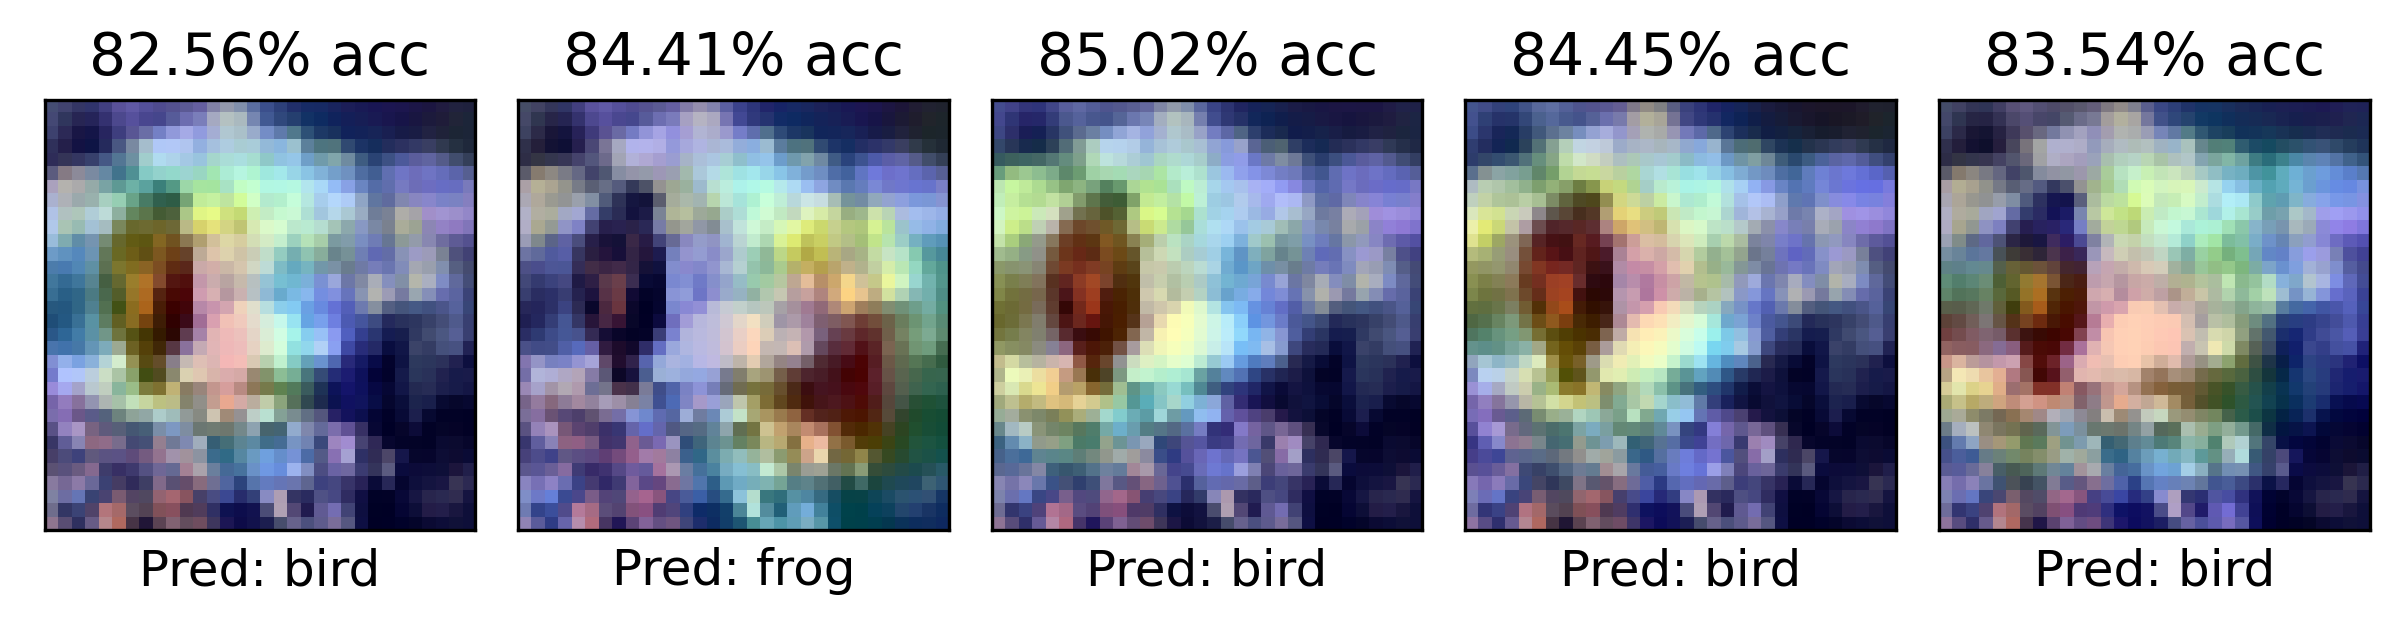

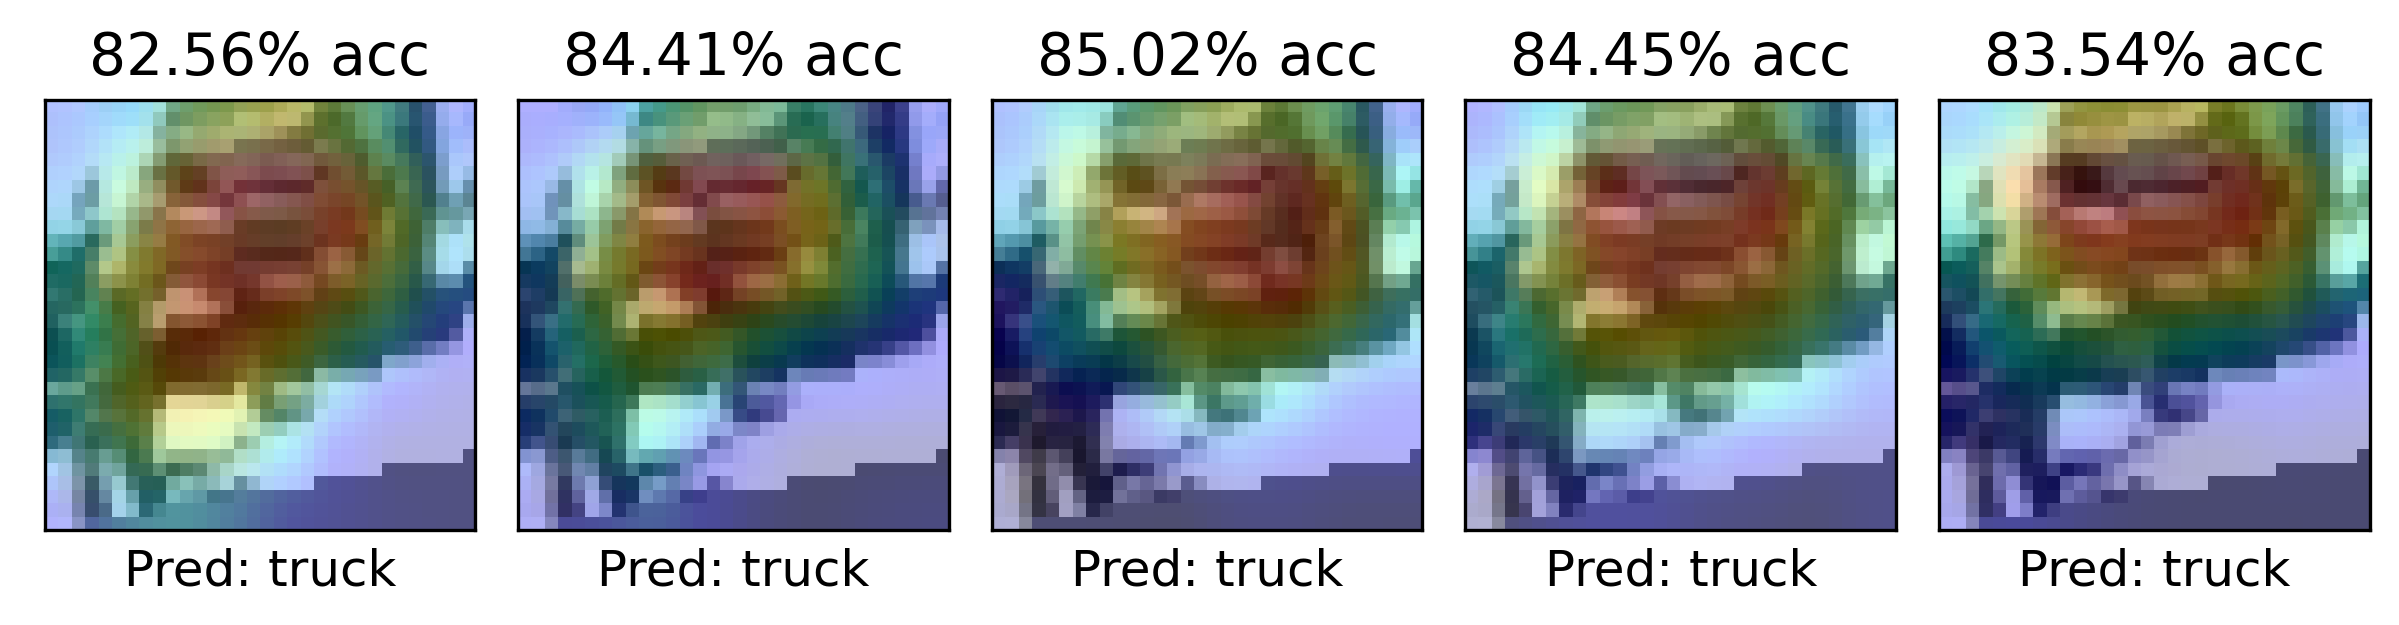

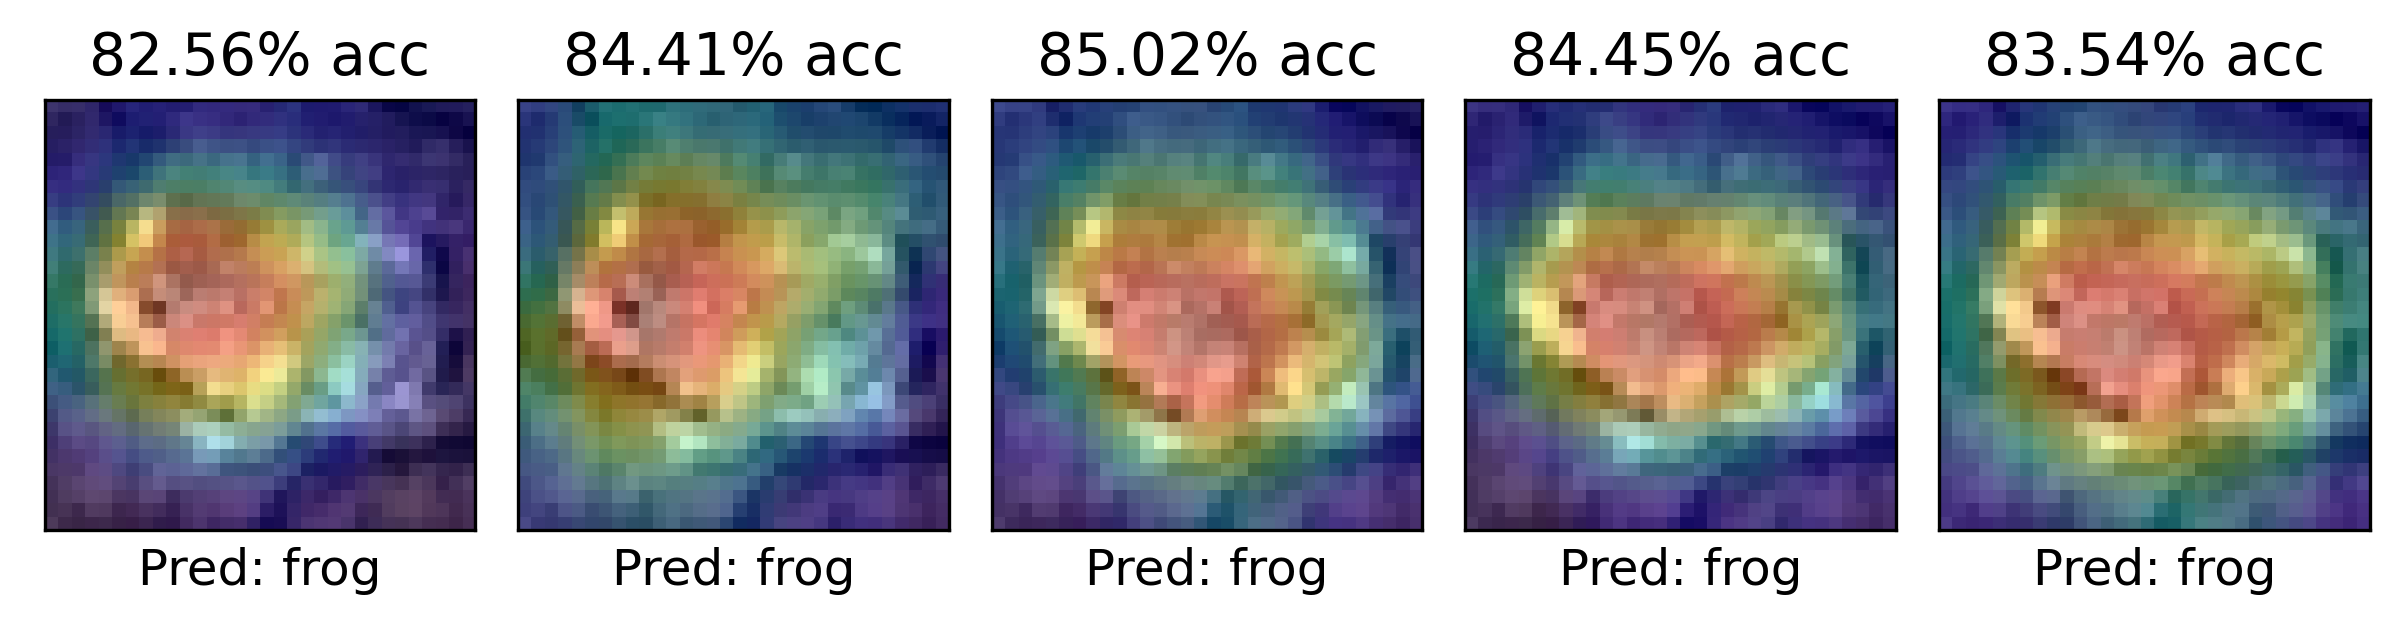

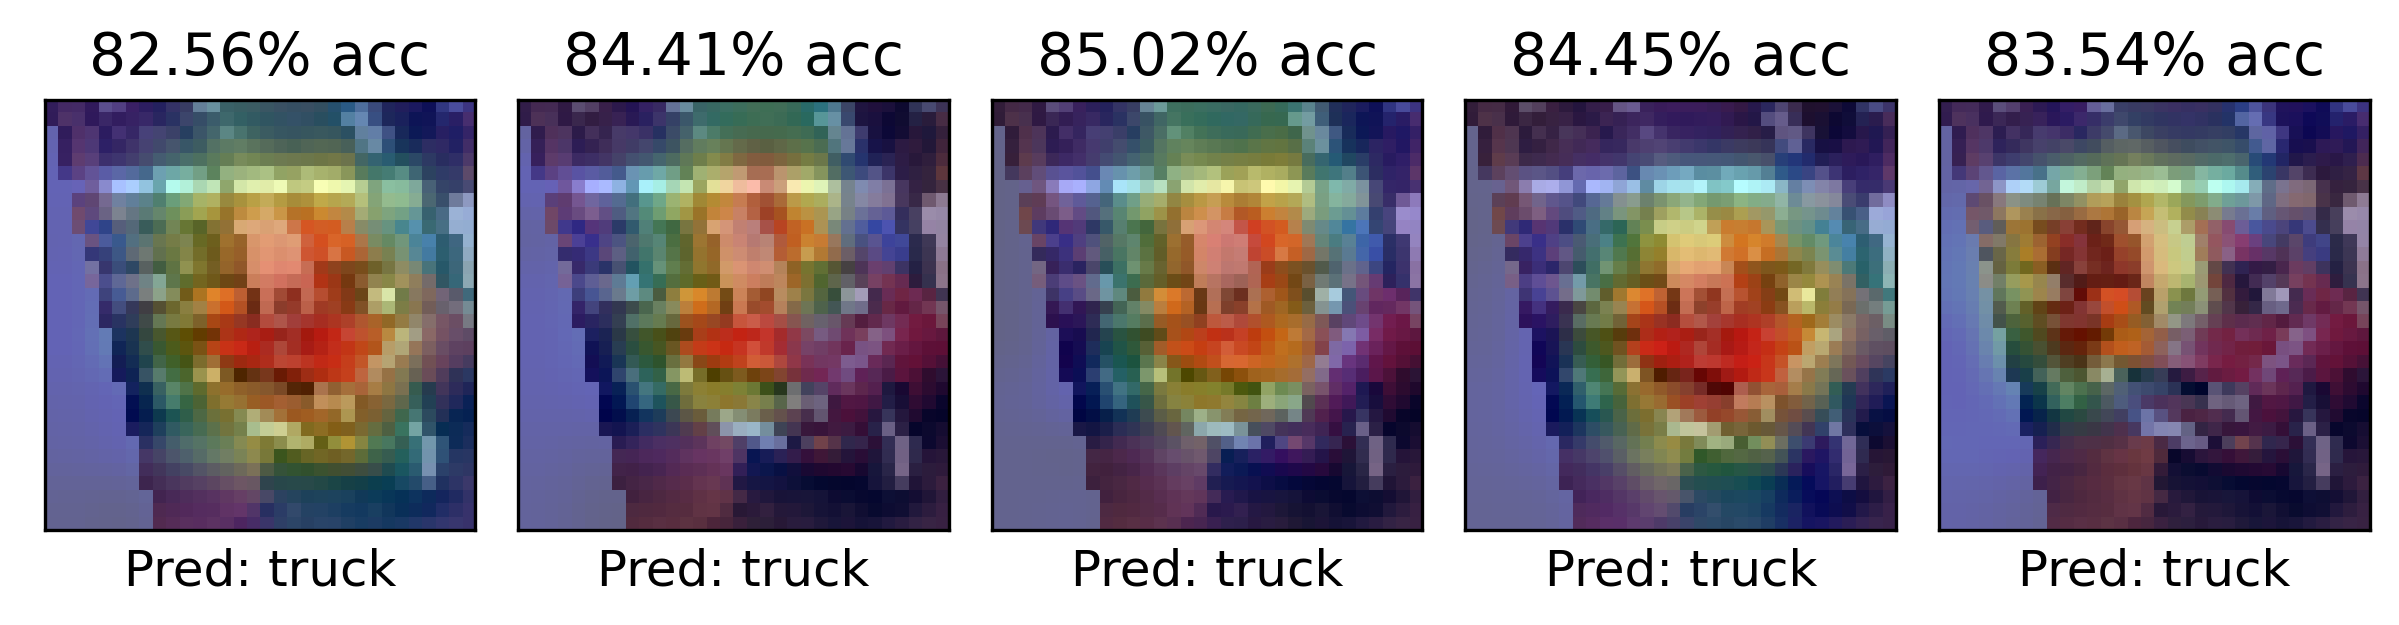

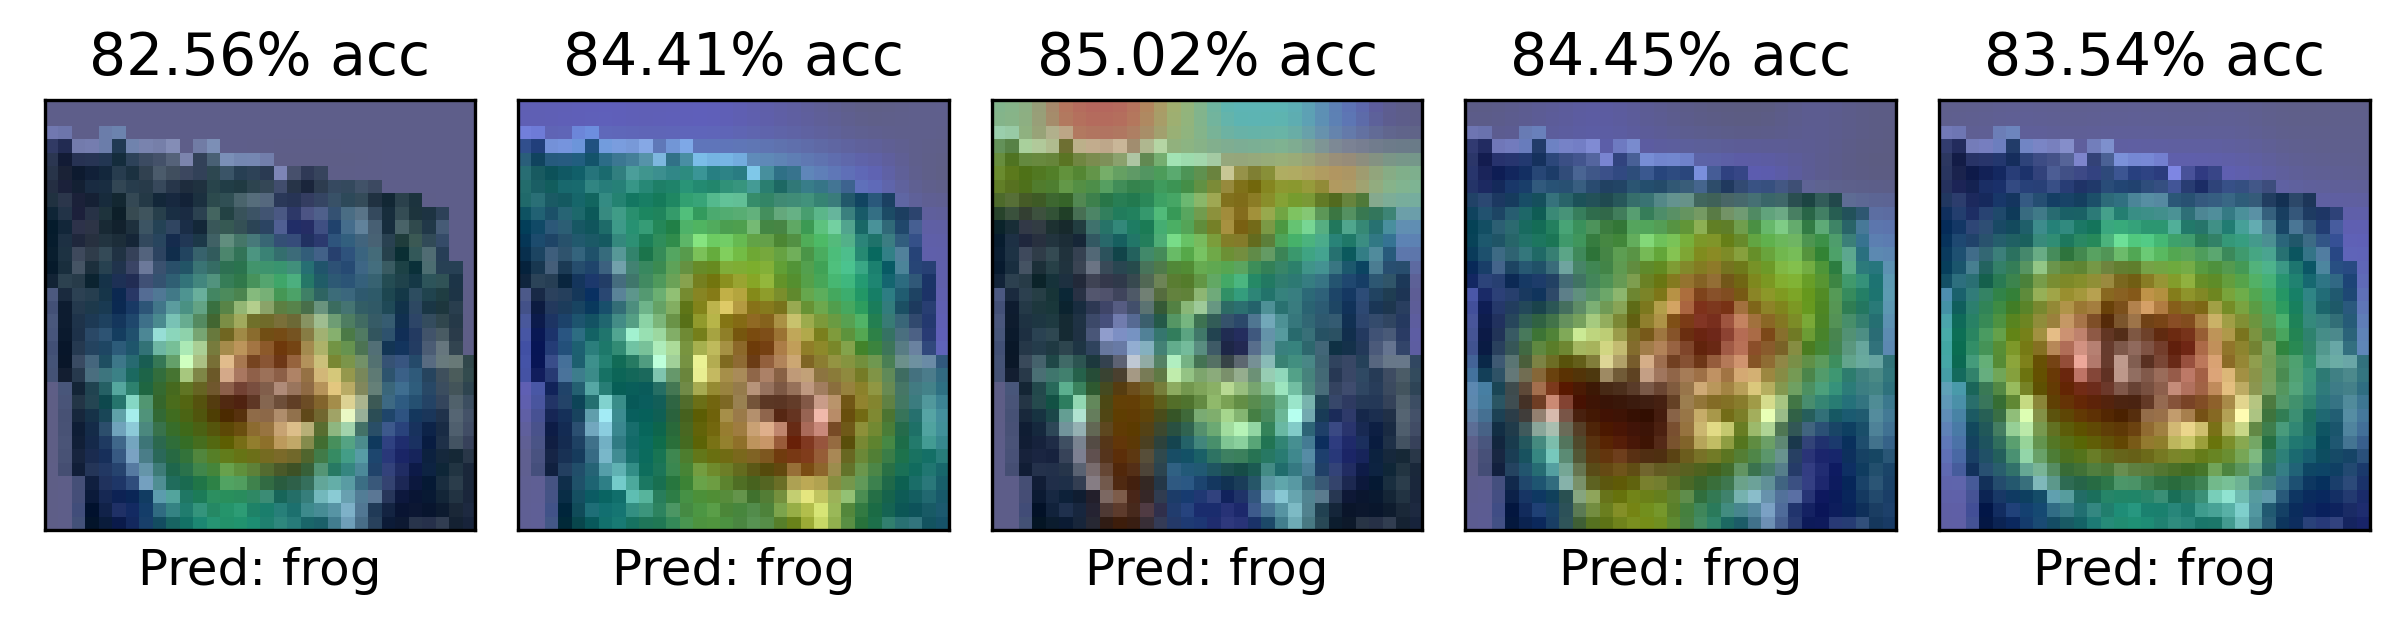

In [34]:
it = iter(
    tfds.as_numpy(test_grad.unbatch().batch(1).skip(skip).take(5).repeat()))

classes = [
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
    "ship", "truck"
]

for i in range(5):
    (s_aa, w_a, s_a, labels) = next(it)
    heatmap_c = make_gradcam_heatmap(s_a, model1)
    heatmap_w = make_gradcam_heatmap(s_a, model2)
    heatmap_s = make_gradcam_heatmap(s_a, model3)
    heatmap_s1 = make_gradcam_heatmap(s_a, model4)
    heatmap_s2 = make_gradcam_heatmap(s_a, model5)
    
    
    heatmap_c_img = combine_heatmap_image(s_a, heatmap_c)
    heatmap_w_img = combine_heatmap_image(s_a, heatmap_w)
    heatmap_s_img = combine_heatmap_image(s_a, heatmap_s)
    heatmap_s1_img = combine_heatmap_image(s_a, heatmap_s1)
    heatmap_s2_img = combine_heatmap_image(s_a, heatmap_s2)

    f, axarr = plt.subplots(1, 5, figsize=(10, 10))
    plt.subplots_adjust(left=0.125,
                        bottom=0.1,
                        right=0.9,
                        top=0.6,
                        wspace=0.1,
                        hspace=0.1)
    axarr[0].imshow(heatmap_c_img[0])
    axarr[0].set_title('82.56% acc', fontsize=14)
    axarr[0].set_xlabel('Pred: ' + classes[np.argmax(model1(s_a), axis=1)[0]],
                        fontsize=12)
    axarr[0].set_xticks([])
    axarr[0].set_xticks([], minor=True)
    axarr[0].set_yticks([])
    axarr[0].set_yticks([], minor=True)

    axarr[1].imshow(heatmap_w_img[0])
    axarr[1].set_title('84.41% acc', fontsize=14)
    axarr[1].set_xlabel('Pred: ' + classes[np.argmax(model2(s_a), axis=1)[0]],
                        fontsize=12)
    axarr[1].set_xticks([])
    axarr[1].set_xticks([], minor=True)
    axarr[1].set_yticks([])
    axarr[1].set_yticks([], minor=True)

    axarr[2].imshow(heatmap_s_img[0])
    axarr[2].set_title('85.02% acc', fontsize=14)
    axarr[2].set_xlabel('Pred: ' + classes[np.argmax(model3(s_a), axis=1)[0]],
                        fontsize=12)
    axarr[2].set_xticks([])
    axarr[2].set_xticks([], minor=True)
    axarr[2].set_yticks([])
    axarr[2].set_yticks([], minor=True)
    
    axarr[3].imshow(heatmap_s1_img[0])
    axarr[3].set_title('84.45% acc', fontsize=14)
    axarr[3].set_xlabel('Pred: ' + classes[np.argmax(model4(s_a), axis=1)[0]],
                        fontsize=12)
    axarr[3].set_xticks([])
    axarr[3].set_xticks([], minor=True)
    axarr[3].set_yticks([])
    axarr[3].set_yticks([], minor=True)
    
    axarr[4].imshow(heatmap_s2_img[0])
    axarr[4].set_title('83.54% acc', fontsize=14)
    axarr[4].set_xlabel('Pred: ' + classes[np.argmax(model5(s_a), axis=1)[0]],
                        fontsize=12)
    axarr[4].set_xticks([])
    axarr[4].set_xticks([], minor=True)
    axarr[4].set_yticks([])
    axarr[4].set_yticks([], minor=True)

    skip += 5